<a href="https://colab.research.google.com/github/Patatone/Analysis-of-the-COVID-19-impact-on-LTE-Networks/blob/main/Analysis_of_the_COVID_19_impact_on_LTE_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install geopandas
%pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 6.3 MB 47.8 MB/s 
     |████████████████████████████████| 16.7 MB 39.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import geopandas
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from google.colab import files

# Import Data


In [3]:
from google.colab import drive
import glob
import os

# Use this Section to import the data files provided in the project folder.

# NETWORK KPI
# Location: Milan ; Reference month: either January, February or March 2020:

## Google drive required lines
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/MRN_data/'

## Local path required lines
# file_path = ''

# KPIs
# We select January, February and March
all_files = glob.glob(os.path.join(file_path , "Milano_800*.csv"))
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

data = pd.concat(li, axis=0, ignore_index=True)

data.drop(['Unnamed: 0'], axis=1, inplace=True)
data['Date'] = pd.to_datetime(data['Date'])

# Cells Location:
locations = pd.read_csv(file_path+'Coordinates_MILANO.csv')

# Drop all possible duplicate rows and drop all possible rows with any NaN and NaT values
locations = locations.drop_duplicates().dropna()

# https://pandas.pydata.org

# This section shows some information regarding the dataset
print(20*'*')
print('Data types:\n')
print(data.dtypes)
print(20*'*')  
print('Number of data points: ', len(data))
print('Number of columns in the dataset: ', len(data.columns))
print(20*'*')
print(data.isnull().sum(axis=0)) # this command show the number of NON valid data points for each column of the dataset:
                                 # a KPI measure for some timestamp can get lost during the storing procedure
print(20*'*')

Mounted at /content/drive
********************
Data types:

REGIONE                    object
COMUNE                     object
Date               datetime64[ns]
ECELL_ID                   object
DL_BW                     float64
RRC_S_SR                  float64
RRC_RE_SR                 float64
ERAB_S_SR                 float64
CS_SR                     float64
IntraF_Hout_SR            float64
InterF_Hout_SR            float64
Hin_SR                    float64
DL_VOL                    float64
UL_VOL                    float64
DL_THR_AVG                float64
UL_THR_AVG                float64
DL_THR_MAX                float64
UL_THR_MAX                float64
USERNUM_MAX               float64
PRB_DL_Used_Avg           float64
PRB_UL_Used_Avg           float64
dtype: object
********************
Number of data points:  841085
Number of columns in the dataset:  21
********************
REGIONE                0
COMUNE                 0
Date                   0
ECELL_ID               0
D

In [4]:
# Here you can understand the size of the scenario, 
# i.e., how many cells you are considering.
print('Number of (distinct) cells: ', len(data.drop_duplicates(subset='ECELL_ID')))


Number of (distinct) cells:  398


# Data Pre-Processing

In [5]:
# We can split the dataset into tree perdios:
# Full lockdown -> from "9th March 2020" to "31th March 2020"(last data)
# Restrictions -> from "16th February 2020" to "9th March 2020"
# Covid free - > from "1 January 2020"(first data) to "16th February 2020"

full_lockdown_end_date = pd.Timestamp(year=2020, month=4, day=1, hour = 0, minute =1)
full_lockdown_start_date = pd.Timestamp(year=2020, month=3, day=8, hour = 23, minute =59)

restrictions_end_date = pd.Timestamp(year=2020, month=3, day=10, hour = 0, minute =1)
restrictions_start_date = pd.Timestamp(year=2020, month=2, day=15, hour = 23, minute =59)

covid_free_end_date = pd.Timestamp(year=2020, month=2, day=17, hour = 0, minute =1)
covid_free_start_date = pd.Timestamp(year=2019, month=12, day=12, hour = 23, minute =59)


full_lockdown = data[data['Date'] < full_lockdown_end_date]
full_lockdown = full_lockdown[full_lockdown['Date'] > full_lockdown_start_date]

restrictions = data[data['Date'] < restrictions_end_date]
restrictions = restrictions[restrictions['Date'] > restrictions_start_date]

covid_free = data[data['Date'] < covid_free_end_date]
covid_free = covid_free[covid_free['Date'] > covid_free_start_date]


In [6]:
# Typically, daily and night KPIs traces are analysed differently, as network users 
# show very different behaviours depending on the two moments. 
#In this section, the considered weekly data are grouped into Daily (from 6AM to 24 PM) 
# and Night (from 00 AM to 6 AM) Data

# January
#week_day = week.set_index('Date').between_time('06:00:00', '23:59:59')
#week_night = week.set_index('Date').between_time('00:00:00', '05:59:59')


In [7]:
def print_cluster_pattern(dataset):
  dt = dataset.copy()
  display(dataset)
  df1 = dt[dt['Clusters'] == 0]

  plt.plot(list(range(0,len(df1))), df1['DL_VOL'])
  plt.show()

  df2 = dt[dt['Clusters'] == 1]

  plt.plot(list(range(0,len(df2))), df2['DL_VOL'])
  plt.show()

  df3 = dt[dt['Clusters'] == 2]

  plt.plot(list(range(0,len(df3))), df3['DL_VOL'])
  plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,ENODEB_ID,DL_VOL,Hour,Weekday
283378,930b285c764e554f338f671864b30d3941935b00,31770560.0,12,5
283379,930b285c764e554f338f671864b30d3941935b00,29351280.0,17,5
283380,930b285c764e554f338f671864b30d3941935b00,21261520.0,16,5
283381,930b285c764e554f338f671864b30d3941935b00,28403648.0,15,5
283382,930b285c764e554f338f671864b30d3941935b00,32426144.0,14,5
...,...,...,...,...
841080,3fdbc872d547a3c5b6404cb90960ed717085fa0b,14161896.0,15,3
841081,3fdbc872d547a3c5b6404cb90960ed717085fa0b,12487416.0,13,3
841082,3fdbc872d547a3c5b6404cb90960ed717085fa0b,15583752.0,12,3
841083,3fdbc872d547a3c5b6404cb90960ed717085fa0b,15207120.0,20,3


,DL_VOL,ENODEB_ID,Hour,Weekday
0,3694572.0,0215f23cbc0c6fed80ce30cb131bc9ed2a745328,6,0
1,2695936.0,0215f23cbc0c6fed80ce30cb131bc9ed2a745328,6,1
2,2866480.0,0215f23cbc0c6fed80ce30cb131bc9ed2a745328,6,2
3,1661272.0,0215f23cbc0c6fed80ce30cb131bc9ed2a745328,7,0
4,775160.0,0215f23cbc0c6fed80ce30cb131bc9ed2a745328,7,1
...,...,...,...,...
7501,8411016.0,fedae7d9d5021026b90211ad6e640aba57634d8e,22,1
7502,12332144.0,fedae7d9d5021026b90211ad6e640aba57634d8e,22,2
7503,8439460.0,fedae7d9d5021026b90211ad6e640aba57634d8e,23,0
7504,8705952.0,fedae7d9d5021026b90211ad6e640aba57634d8e,23,1


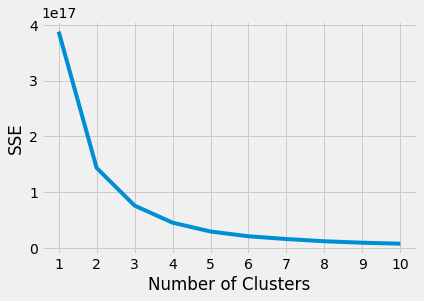


Perfect "k" value for the KMeans algorithm: 3



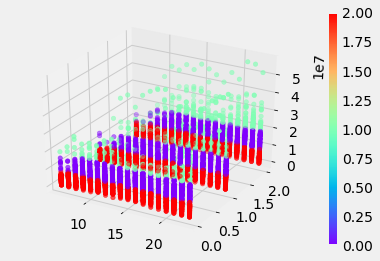

,DL_VOL,ENODEB_ID,Hour,Weekday,Clusters
0,3694572.0,0215f23cbc0c6fed80ce30cb131bc9ed2a745328,6,0,2
1,2695936.0,0215f23cbc0c6fed80ce30cb131bc9ed2a745328,6,1,2
2,2866480.0,0215f23cbc0c6fed80ce30cb131bc9ed2a745328,6,2,2
3,1661272.0,0215f23cbc0c6fed80ce30cb131bc9ed2a745328,7,0,2
4,775160.0,0215f23cbc0c6fed80ce30cb131bc9ed2a745328,7,1,2
...,...,...,...,...,...
7501,8411016.0,fedae7d9d5021026b90211ad6e640aba57634d8e,22,1,2
7502,12332144.0,fedae7d9d5021026b90211ad6e640aba57634d8e,22,2,0
7503,8439460.0,fedae7d9d5021026b90211ad6e640aba57634d8e,23,0,2
7504,8705952.0,fedae7d9d5021026b90211ad6e640aba57634d8e,23,1,0


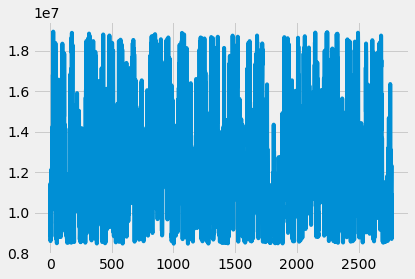

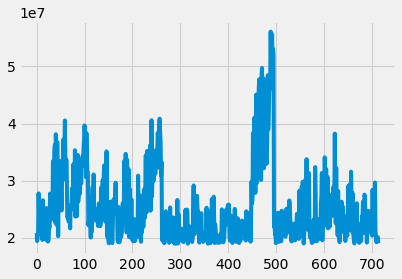

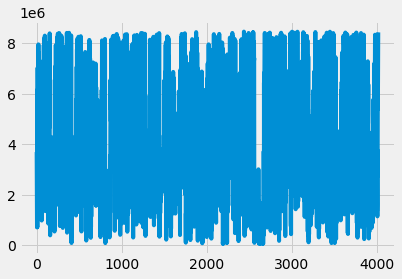

139


,ENODEB_ID,Clusters
0,0215f23cbc0c6fed80ce30cb131bc9ed2a745328,2
1,06aae15c9629c9678edd56657192be30db5934d4,2
2,097e1d4a277e6d01e669ce5cc4451385373f765c,0
3,0b3ac99f984ed5eebd90e63eb0cd243e80fe0122,0
4,0c37e6369bb6f6804dd9a9520f9f09e09e659dac,0
...,...,...
134,f3d8f663b55d0e09e776e3144bf1ccdb6fad4048,0
135,f9ea6c0f0f54b40ac1d2a71da53b398109f7b379,2
136,fad7e3b8304ec998840271a7a79029a250592fe3,2
137,fb1af0ff1366d50bd7545ce7f6bb487a005153e9,2


60
13
66


,ENODEB_ID,ECELL_ID,LONG_X,LAT_Y,geometry
0,6c6e77c44a598b0e34a0ff19832137cc24a31db7,6807ba8768ea1c61b922795a02dd6e8c1f5823e1,9.214511,45.469421,POINT (9.21451 45.46942)
1,6c6e77c44a598b0e34a0ff19832137cc24a31db7,8d22026fa4296af87b0cc18fe624dab8b4380f5f,9.214511,45.469421,POINT (9.21451 45.46942)
2,6c6e77c44a598b0e34a0ff19832137cc24a31db7,ec23991911b3cfb4ea95872ff7c33f3b94a4ed8c,9.214511,45.469421,POINT (9.21451 45.46942)
3,6c6e77c44a598b0e34a0ff19832137cc24a31db7,19f1db7780506e3ca6e4510fe9eacea8780b8a57,9.214511,45.469421,POINT (9.21451 45.46942)
4,6c6e77c44a598b0e34a0ff19832137cc24a31db7,118b2380aa908cf5dbb4dd9a2a7c7a8c01cf3df5,9.214511,45.469421,POINT (9.21451 45.46942)
...,...,...,...,...,...
337,f161d41795890db558d3e34b6ddd61bda77e8764,dfee8b67dd0f806325484e2fd32e1bdcb93bd491,9.175056,45.460056,POINT (9.17506 45.46006)
338,f161d41795890db558d3e34b6ddd61bda77e8764,963d7b7a00e2b9c7d20fe313dced0388be5b4dac,9.175056,45.460056,POINT (9.17506 45.46006)
339,f161d41795890db558d3e34b6ddd61bda77e8764,6e400cb348d501fe7cc36f7dffe9f61ea2f0fda4,9.175056,45.460056,POINT (9.17506 45.46006)
340,f161d41795890db558d3e34b6ddd61bda77e8764,7e071b24a187a5f5a51788325ba163393c2e747f,9.175056,45.460056,POINT (9.17506 45.46006)


,ENODEB_ID,ECELL_ID,LONG_X,LAT_Y,geometry
0,930b285c764e554f338f671864b30d3941935b00,b7de6cd46e855aaec8e28b26d1767e7a738819db,9.208433,45.445358,POINT (9.20843 45.44536)
1,930b285c764e554f338f671864b30d3941935b00,3821116bcdc789c9d54369ddd58b8e75fafdcb59,9.208433,45.445358,POINT (9.20843 45.44536)
2,930b285c764e554f338f671864b30d3941935b00,9ed9d0f30e21c0218c987496c433e11dd611c9d2,9.208433,45.445358,POINT (9.20843 45.44536)
3,930b285c764e554f338f671864b30d3941935b00,9ba7c2a7f2ae3a32003cd92d0ce82fdd734f1d7f,9.208433,45.445358,POINT (9.20843 45.44536)
4,930b285c764e554f338f671864b30d3941935b00,ce8ca39728288e4065ec86b14e902807327427ff,9.208433,45.445358,POINT (9.20843 45.44536)
...,...,...,...,...,...
375,3fdbc872d547a3c5b6404cb90960ed717085fa0b,82a9f5269531147ac5ce15ff92fd8172d1ff0bcf,9.158972,45.505527,POINT (9.15897 45.50553)
376,3fdbc872d547a3c5b6404cb90960ed717085fa0b,3b99faafa552a3deb33f45826e79bec090cc4084,9.158972,45.505527,POINT (9.15897 45.50553)
377,3fdbc872d547a3c5b6404cb90960ed717085fa0b,2be222cdb25c37650735f9a18e575cdaec91e995,9.158972,45.505527,POINT (9.15897 45.50553)
378,3fdbc872d547a3c5b6404cb90960ed717085fa0b,5d0ba788e727644a8aeecdc64f230a63b1465c66,9.158972,45.505527,POINT (9.15897 45.50553)


,ENODEB_ID,ECELL_ID,LONG_X,LAT_Y,geometry
0,20dc89dfa2970fba49975c8021d729dbb93d9c86,5a6ea208eb7b2dcbf59dc457706b8b04a5a8e1b2,9.193417,45.444824,POINT (9.19342 45.44482)
1,20dc89dfa2970fba49975c8021d729dbb93d9c86,b713a4f2dc59f35a0dfa1e598cf4cf01659bd2e8,9.193417,45.444824,POINT (9.19342 45.44482)
2,20dc89dfa2970fba49975c8021d729dbb93d9c86,b7eed02edd74696bf65d055085787772478961de,9.193417,45.444824,POINT (9.19342 45.44482)
3,20dc89dfa2970fba49975c8021d729dbb93d9c86,54ebd03cfb35c525f14319bf13ec472fd48ff82d,9.193417,45.444824,POINT (9.19342 45.44482)
4,20dc89dfa2970fba49975c8021d729dbb93d9c86,92a9a40e50f92b2225a357de69a69b986bd5b382,9.193417,45.444824,POINT (9.19342 45.44482)
...,...,...,...,...,...
71,4098516471522b42b596da741a12b408af23877a,6805bcdd345fe8aceaf193d5cd0efec689627cfd,9.196639,45.471111,POINT (9.19664 45.47111)
72,4098516471522b42b596da741a12b408af23877a,127cd95aaab8bc59186b5db827b82b2ffa4fc635,9.196639,45.471111,POINT (9.19664 45.47111)
73,4098516471522b42b596da741a12b408af23877a,0527e8c4cf3eb08af45d118c6783eed34f28bd50,9.196639,45.471111,POINT (9.19664 45.47111)
74,4098516471522b42b596da741a12b408af23877a,a03f758431bdd90bf1b2beef5f7f86df187bfeb8,9.196639,45.471111,POINT (9.19664 45.47111)


In [42]:
# CLUSTERING PART 

#filtering by weekdays and daily business hours
x = covid_free[covid_free['Date'].dt.hour.between(6, 24)]

hours = pd.to_datetime(x['Date']).dt.hour
weekdays = x['Date'].dt.weekday
x['Hour'] = hours
x['Weekday'] = weekdays

x = x.join(locations.set_index('ECELL_ID'), on='ECELL_ID')

#creating dataset with relevant data from previous DataFrame
x = x[['ENODEB_ID', 'DL_VOL', 'Hour', 'Weekday']]
#x = x.groupby(['ENODEB_ID', 'Hour', 'Weekday']).median()
display(x)

#splitting between week and weekend days
x['Weekday'] = x['Weekday'].apply(lambda x : 0 if x < 5 else (1 if x == 5 else 2))

x = x.groupby(['ENODEB_ID', 'Hour', 'Weekday'], as_index=False).agg({'DL_VOL': 'median', 'ENODEB_ID': 'first', 'Hour': 'first', 'Weekday': 'first'})
#x['DL_VOL'] = x.groupby(['ENODEB_ID', 'Hour', 'Weekday'])['DL_VOL'].median()
x = x.reset_index(drop=True)

display(x)

#scaler = StandardScaler()
#x[['DL_VOL', 'Hour', 'Weekday']] = scaler.fit_transform(x[['DL_VOL', 'Hour', 'Weekday']])

#display(x)

kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 0,
    }

# selecting the DL_Volume column as entry data for the k-means clustering algorithm
dl_array = x[['DL_VOL', 'Hour', 'Weekday']]
sse = []
for k in range(1, 11):
  # creating a 2 clusters k-means value clustering class and fitting the DataFrame accordingly
  kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
  identified_clusters = kmeans.fit(dl_array)
  sse.append(kmeans.inertia_)

plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()
print()

# Determining the elbow point in the SSE curve
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
k = kl.elbow
print('Perfect "k" value for the KMeans algorithm:', k)
print()

# creating a "k" clusters k-means value clustering class and fitting the DataFrame accordingly
kmeans = KMeans(n_clusters=k).fit(dl_array)
identified_clusters = kmeans.fit_predict(dl_array)
data_with_clusters = x.copy()
data_with_clusters['Clusters'] = identified_clusters

# Scattering the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
img = ax.scatter(data_with_clusters['Hour'], data_with_clusters['Weekday'], data_with_clusters['DL_VOL'], c = data_with_clusters['Clusters'],
            cmap='rainbow')
fig.colorbar(img)
plt.show()

print_cluster_pattern(data_with_clusters)


#data_with_clusters = data_with_clusters.groupby(['ENODEB_ID', 'Hour'], as_index=False).agg({'DL_VOL': 'first', 'ENODEB_ID': 'first', 'Hour': 'first', 'Weekday': 'first', 'Clusters': 'mode'})
#data_with_clusters = data_with_clusters.groupby(['ENODEB_ID', 'Hour'], as_index=False)['Clusters'].apply(lambda x: x.mode().iloc[0])
data_with_clusters = data_with_clusters.groupby('ENODEB_ID')['Clusters'].apply(lambda x: x.value_counts().index[0]).reset_index()
print(len(data_with_clusters))
display(data_with_clusters)

# Splitting residential cells from non-residential ones
support_residential = data_with_clusters[data_with_clusters['Clusters'] == 0]
print(len(support_residential))
support_promiscuous = data_with_clusters[data_with_clusters['Clusters'] == 1]
print(len(support_promiscuous))
support_business = data_with_clusters[data_with_clusters['Clusters'] == 2]
print(len(support_business))

support_residential = support_residential.reset_index()
support_business = support_business.reset_index()
support_promiscuous = support_promiscuous.reset_index()

data_enodebs = data.join(locations.set_index('ECELL_ID'), on='ECELL_ID')
# Splitting all the data according to the clusters
residential_data = data.loc[data_enodebs['ENODEB_ID'].isin(support_residential['ENODEB_ID'])].reset_index(drop=True)
business_data = data.loc[data_enodebs['ENODEB_ID'].isin(support_business['ENODEB_ID'])].reset_index(drop=True)
promiscuous_data = data.loc[data_enodebs['ENODEB_ID'].isin(support_promiscuous['ENODEB_ID'])].reset_index(drop=True)

# Splitting all the locations according to the clusters
residential_locations = locations.loc[locations['ENODEB_ID'].isin(support_residential['ENODEB_ID'])].reset_index(drop=True)
business_locations = locations.loc[locations['ENODEB_ID'].isin(support_business['ENODEB_ID'])].reset_index(drop=True)
promiscuous_locations = locations.loc[locations['ENODEB_ID'].isin(support_promiscuous['ENODEB_ID'])].reset_index(drop=True)

display(residential_locations)
display(business_locations)
display(promiscuous_locations)


In [43]:
# We can split the CLUSTERED dataset into tree perdios:
# Full lockdown -> from "9th March 2020" to "31th March 2020"(last data)
# Restrictions -> from "16th February 2020" to "9th March 2020"
# Covid free - > from "1 January 2020"(first data) to "16th February 2020"

full_lockdown_residential = residential_data[residential_data['Date'] < full_lockdown_end_date]
full_lockdown_residential = full_lockdown_residential[full_lockdown_residential['Date'] > full_lockdown_start_date]

full_lockdown_business = business_data[business_data['Date'] < full_lockdown_end_date]
full_lockdown_business = full_lockdown_business[full_lockdown_business['Date'] > full_lockdown_start_date]

restrictions_residential = residential_data[residential_data['Date'] < restrictions_end_date]
restrictions_residential = restrictions_residential[restrictions_residential['Date'] > restrictions_start_date]

restrictions_business = business_data[business_data['Date'] < restrictions_end_date]
restrictions_business = restrictions_business[restrictions_business['Date'] > restrictions_start_date]

covid_free_residential = residential_data[residential_data['Date'] < covid_free_end_date]
covid_free_residential = covid_free_residential[covid_free_residential['Date'] > covid_free_start_date]

covid_free_business = business_data[business_data['Date'] < covid_free_end_date]
covid_free_business = covid_free_business[covid_free_business['Date'] > covid_free_start_date]

periods_lables = ['Covid Free','Restrictions','Full Lockdown']
periods_data = [covid_free, restrictions, full_lockdown]
for i in range(0, 3):
  print('Number of', periods_lables[i], 'data points:', len(periods_data[i]))


Number of Covid Free data points: 434975
Number of Restrictions data points: 217267
Number of Full Lockdown data points: 208081


# Data Visualization

Original dataset size: 840295
Cleaned dataset size: 840295


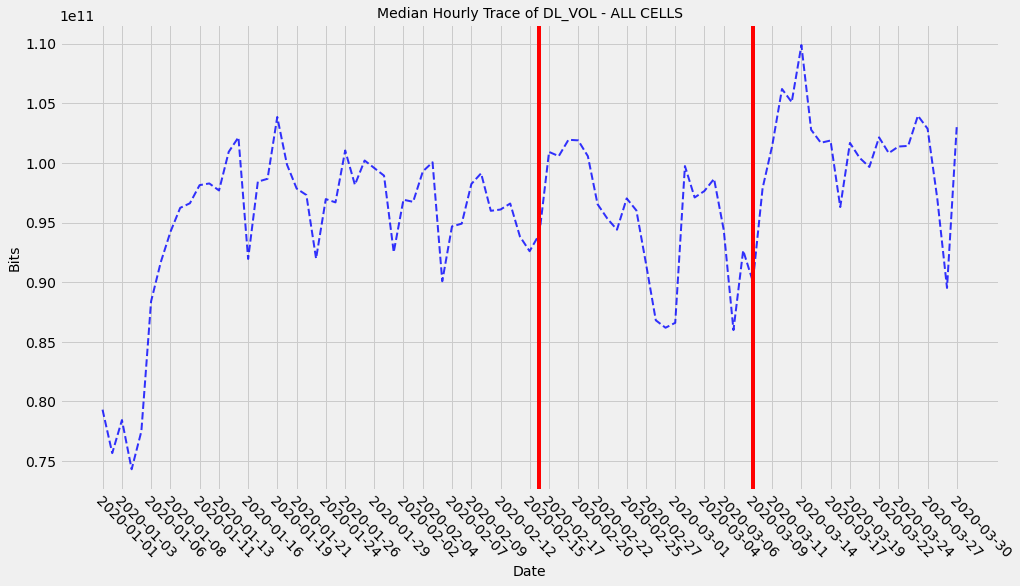


Original dataset size: 840295
Cleaned dataset size: 840295


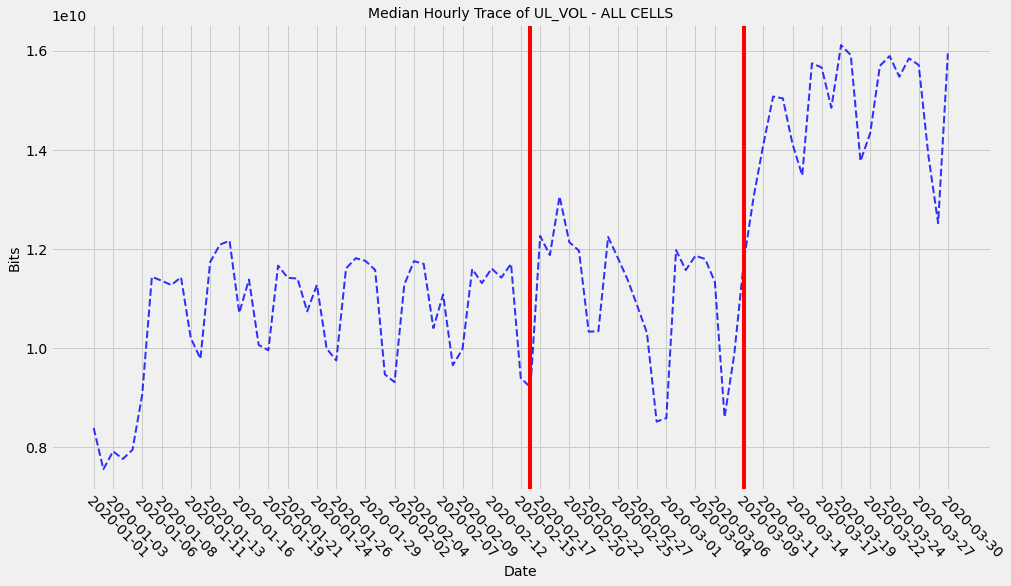

In [44]:
# This section plots the Traffic Downloaded from the ALL cells in a month

def periods_trace_plot_daily(ref_KPI, operation, ylabel):
  # Create a copy of the original dataset
  data_temp = data.copy()

  # Set Daily granularity instead of Hourly granularity
  data_temp['Date'] = pd.to_datetime(data_temp['Date']).dt.date

  # Used to identify days with less measurments
  # pd.set_option('display.max_rows', None)
  # display(data_temp['Date'].value_counts())

  # We drop the data about 31-03-2020 because we are computing daily stats and in this date we have only one measurment for the whole day
  ref = data_temp.set_index('Date').sort_values('Date').drop(datetime.date(year=2020,month=3,day=31)).loc[:, [ref_KPI]]

  print('Original dataset size:', len(ref))
  print('Cleaned dataset size:', len(ref.dropna()))

  # Sum all the "ref_KPI" values with same "Date"
  ref = ref.groupby(level=0).sum()

  # open new figure
  fig, ax = plt.subplots(figsize=(15,8))

  # plot data
  ax.plot(list(range(0,len(ref))), ref[ref_KPI], linestyle='--', lw=2, color='b', alpha=.8) 

  # Set plotting options
  plt.xticks(color='black')
  plt.yticks(color='black')
  plt.grid(1)
  ticks_label = ref.index
  ticks = np.linspace(0, len(ref)-1, 35, dtype=int)
  plt.xticks(ticks = ticks, labels = ticks_label[ticks], fontsize = 14)
  plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor") 
  plt.xlabel('Date', color='black', fontsize=14)
  plt.ylabel(ylabel, color='black', fontsize=14) # unit of measure depends on the considered KPI
  plt.title('Median Hourly Trace of '+ref_KPI+' - ALL CELLS', fontsize=14)

  # Draw a red line when there is a period change
  plt.axvline(ticks_label.get_loc(datetime.date(year=2020,month=2,day=16)) ,color = 'r',label = 'Restrictions')
  plt.axvline(ticks_label.get_loc(datetime.date(year=2020,month=3,day=9)) ,color = 'r',label = 'Full Lockdown')

  plt.show()

periods_trace_plot_daily('DL_VOL', 0, 'Bits')
print()
periods_trace_plot_daily('UL_VOL', 0, 'Bits')
print()

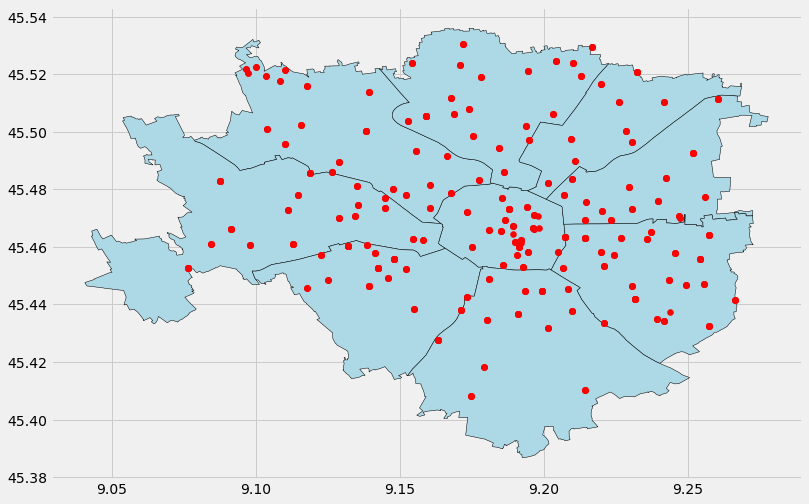

In [45]:
# Cell rappresentation with Geopandas
geo_data = geopandas.GeoDataFrame(locations, geometry=geopandas.points_from_xy(locations.LONG_X, locations.LAT_Y))

# Plot the map
milan = geopandas.read_file(file_path+'ds379_municipi_label.geojson')
ax = milan.plot(color='lightblue', edgecolor='black', figsize=[12,15])

# Plot the cells
geo_data.plot(ax=ax, color='red')
plt.show()


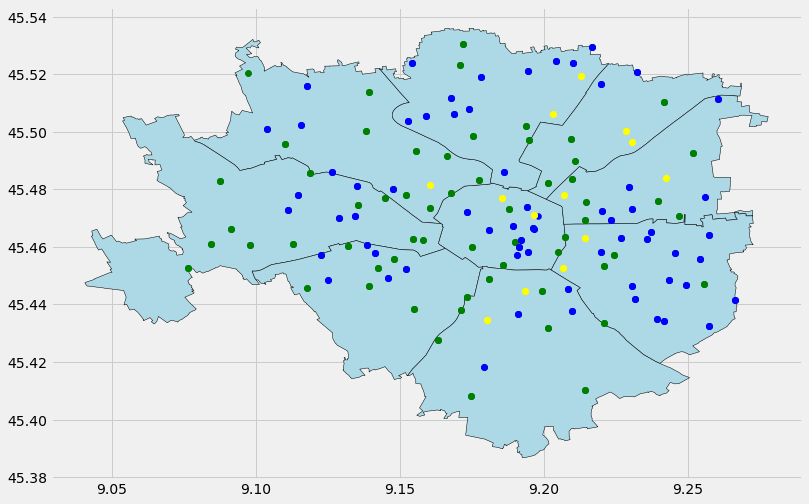

In [46]:
# Cell differentiation with Geopandas
geo_data_residential = geopandas.GeoDataFrame(residential_locations, geometry=geopandas.points_from_xy(residential_locations.LONG_X, residential_locations.LAT_Y))
geo_data_business = geopandas.GeoDataFrame(business_locations, geometry=geopandas.points_from_xy(business_locations.LONG_X, business_locations.LAT_Y))
geo_data_promiscuous  = geopandas.GeoDataFrame(promiscuous_locations, geometry=geopandas.points_from_xy(promiscuous_locations.LONG_X, promiscuous_locations.LAT_Y))

# Plot the map
milan = geopandas.read_file(file_path+'ds379_municipi_label.geojson')
ax = milan.plot(color='lightblue', edgecolor='black', figsize=[12,15])

# Plot the cells
geo_data_residential.plot(ax=ax, color='green')
geo_data_business.plot(ax=ax, color='blue')
geo_data_promiscuous.plot(ax=ax, color='yellow')
plt.show()

In [47]:
# This section makes a box plot of the daily statiscs regarding the number of connected 
# users to the cell taken as example. For each day, the following statistics are extracted from the considered
# KPI:
# - Median Value
# - 25th and 75th Quantiles
# - Max and Min values

# For reference about how to read a box plot go here: 
# https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51


def data_dataset_daily(dataset, ref_KPI):
  # Set Daily granularity instead of Hourly granularity
  dataset['Date'] = pd.to_datetime(dataset['Date']).dt.date
  # Set new dataset index to "Date" and keep only the "ref_KPI" column
  return dataset.set_index('Date').sort_values('Date').loc[:, [ref_KPI]]


# If operation == 0 do the sum of the ref_KPI of the day
# If operation == 1 do the average of the ref_KPI of the day
def dataset_operation(dataset, operation):
  if operation == 0:
    dataset = dataset.groupby(level=0).sum()
  else:
    dataset = dataset.groupby(level=0).mean()
  return dataset


def statistical_comparison(periods_lables, median_values, average_values, sd_values, id_1, id_2, ref_KPI):
  print('>>>------', periods_lables[id_1], ref_KPI, 'Variation ------<<<')
  print("Median: difference between [", periods_lables[id_1] ,"] and [",periods_lables[id_2] ,"]: {0:.2f}%".format(((median_values[id_2] - median_values[id_1]) / abs(median_values[id_1])) * 100))
  print("Average: difference between [", periods_lables[id_1] ,"] and [",periods_lables[id_2] ,"]: {0:.2f}%".format(((average_values[id_2] - average_values[id_1]) / abs(average_values[id_1])) * 100))
  print("Std. deviation: difference between [", periods_lables[id_1] ,"] and [",periods_lables[id_2] ,"]: {0:.2f}%".format(((sd_values[id_2] - sd_values[id_1]) / abs(sd_values[id_1])) * 100))


def periods_box_plot_daily(periods, periods_lables, ref_KPI, operation, ylabel):

  periods_copy = []
  periods_data_list = []
  N_periods = len(periods)

  for i in range(N_periods):
    periods_copy.append(periods[i].copy())
    periods_copy[i] = data_dataset_daily(periods_copy[i], ref_KPI)
    periods_copy[i] = periods_copy[i].loc[:, [ref_KPI]].drop(datetime.date(year=2020,month=3,day=31), errors='ignore')
    # Remove null values
    periods_copy[i] = periods_copy[i].dropna()
    periods_copy[i] = dataset_operation(periods_copy[i], ref_KPI)
    # periods_copy have only one KPI but we need "[ref_KPI]" to use the "tolist()" function
    periods_data_list.append(periods_copy[i][ref_KPI].tolist())

  # open new figure
  fig, ax = plt.subplots(figsize=(15,8))

  bplots = []
  for i in range(N_periods):
    bplots.append(ax.boxplot(periods_data_list[i], positions = [i], patch_artist=True))

  for bplot in bplots:
    for patch in bplot['boxes']:
      patch.set_facecolor('lightblue')

  # Set plotting options
  plt.xticks(color='black')
  plt.yticks(color='black')
  plt.grid(1)
  plt.xticks(ticks = list(range(N_periods)), labels = periods_lables, fontsize = 14)
  plt.setp( ax.xaxis.get_majorticklabels(), ha="center") 
  plt.ylabel(ylabel, color='black', fontsize=14)
  if N_periods > 3:
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor") 

  plt.title('Box Plot of Median '+ref_KPI+' - ALL CELLs', fontsize=14)
  plt.show()

  print()
  
  median_values = []
  average_values = []
  sd_values = []

  # Print statistical informations:
  for i in range(N_periods):
    print('---------', periods_lables[i], ref_KPI,'---------')
    median_values.append(np.median(periods_data_list[i]))
    print('Median value:', "{0:.2f}".format(median_values[i]))
    average_values.append(np.mean(periods_data_list[i]))
    print('Average value:', "{0:.2f}".format( average_values[i]))
    sd_values.append(np.std(periods_data_list[i]))
    print('Standard deviation:', "{0:.2f}".format(sd_values[i]))

  if N_periods > 3:
    # Statistical comparison between residential and business in the same period
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 0, 1, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 2, 3, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 4, 5, ref_KPI)

    # Statistical comparison between residential periods
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 0, 2, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 0, 4, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 2, 4, ref_KPI)

    # Statistical comparison between business periods
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 1, 3, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 1, 5, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 3, 5, ref_KPI)
  else:
    # Statistical comparison between periods
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 0, 1, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 0, 2, ref_KPI)
    statistical_comparison(periods_lables, median_values, average_values, sd_values, 1, 2, ref_KPI)


In [48]:
def plot_stats(periods, periods_lables):
  periods_box_plot_daily(periods, periods_lables, 'DL_VOL', 0, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'UL_VOL', 0, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'DL_THR_MAX', 1, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'UL_THR_MAX', 1, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'DL_THR_AVG', 1, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'UL_THR_AVG', 1, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'ERAB_S_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'CS_SR', 1, 'Calls')
  print()
  periods_box_plot_daily(periods, periods_lables, 'RRC_S_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'RRC_RE_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'IntraF_Hout_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'InterF_Hout_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'Hin_SR', 1, 'Success Rate')
  print()
  periods_box_plot_daily(periods, periods_lables, 'PRB_DL_Used_Avg', 1, 'Bits')
  print()
  periods_box_plot_daily(periods, periods_lables, 'PRB_UL_Used_Avg', 1, 'Bits')
  print()

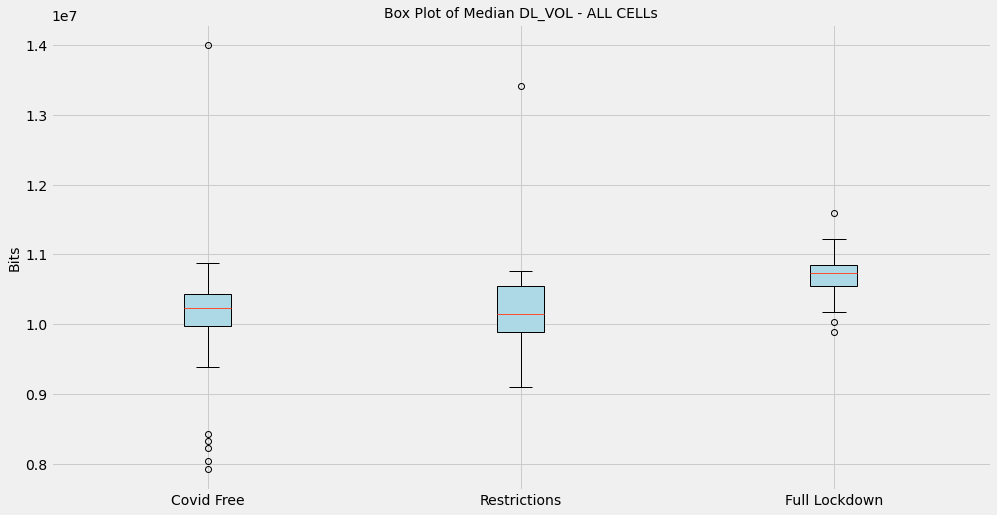


--------- Covid Free DL_VOL ---------
Median value: 10228299.84
Average value: 10098197.62
Standard deviation: 897092.93
--------- Restrictions DL_VOL ---------
Median value: 10155150.32
Average value: 10218866.57
Standard deviation: 820310.10
--------- Full Lockdown DL_VOL ---------
Median value: 10736376.01
Average value: 10692283.22
Standard deviation: 380883.26
>>>------ Covid Free DL_VOL Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -0.72%
Average: difference between [ Covid Free ] and [ Restrictions ]: 1.19%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: -8.56%
>>>------ Covid Free DL_VOL Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 4.97%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 5.88%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -57.54%
>>>------ Restrictions DL_VOL Variation ------<<<
Median: difference between [ Restriction

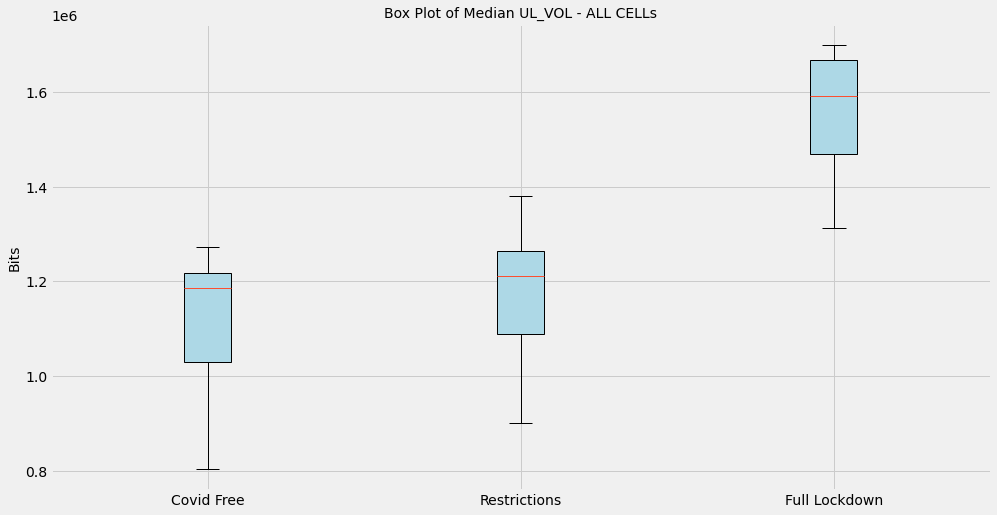


--------- Covid Free UL_VOL ---------
Median value: 1185227.90
Average value: 1119706.01
Standard deviation: 130533.09
--------- Restrictions UL_VOL ---------
Median value: 1211847.29
Average value: 1168873.07
Standard deviation: 132182.07
--------- Full Lockdown UL_VOL ---------
Median value: 1592944.30
Average value: 1562048.34
Standard deviation: 117307.45
>>>------ Covid Free UL_VOL Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: 2.25%
Average: difference between [ Covid Free ] and [ Restrictions ]: 4.39%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 1.26%
>>>------ Covid Free UL_VOL Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 34.40%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 39.51%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -10.13%
>>>------ Restrictions UL_VOL Variation ------<<<
Median: difference between [ Restrictions ] an

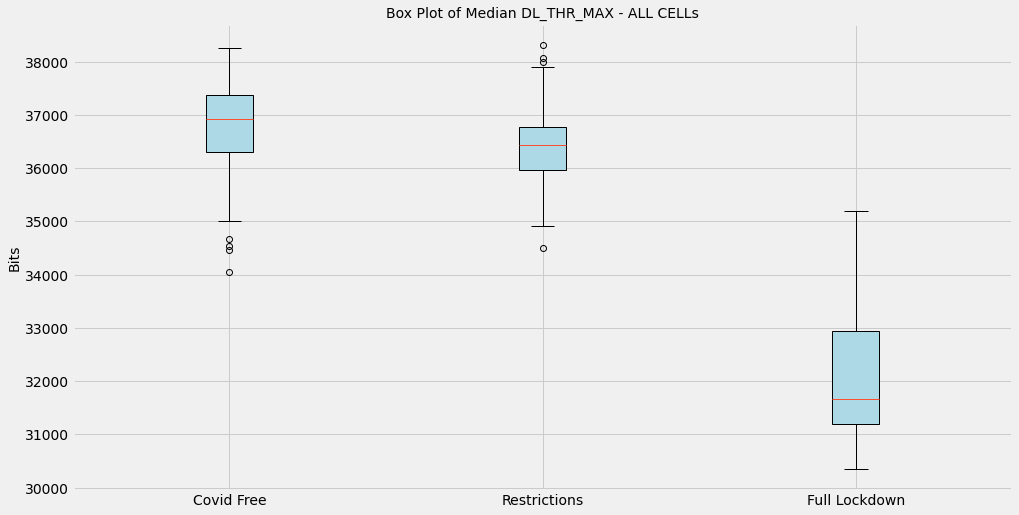


--------- Covid Free DL_THR_MAX ---------
Median value: 36921.34
Average value: 36688.49
Standard deviation: 962.73
--------- Restrictions DL_THR_MAX ---------
Median value: 36431.24
Average value: 36451.33
Standard deviation: 952.23
--------- Full Lockdown DL_THR_MAX ---------
Median value: 31657.86
Average value: 32185.83
Standard deviation: 1308.02
>>>------ Covid Free DL_THR_MAX Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -1.33%
Average: difference between [ Covid Free ] and [ Restrictions ]: -0.65%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: -1.09%
>>>------ Covid Free DL_THR_MAX Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: -14.26%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: -12.27%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: 35.87%
>>>------ Restrictions DL_THR_MAX Variation ------<<<
Median: difference between [ Restricti

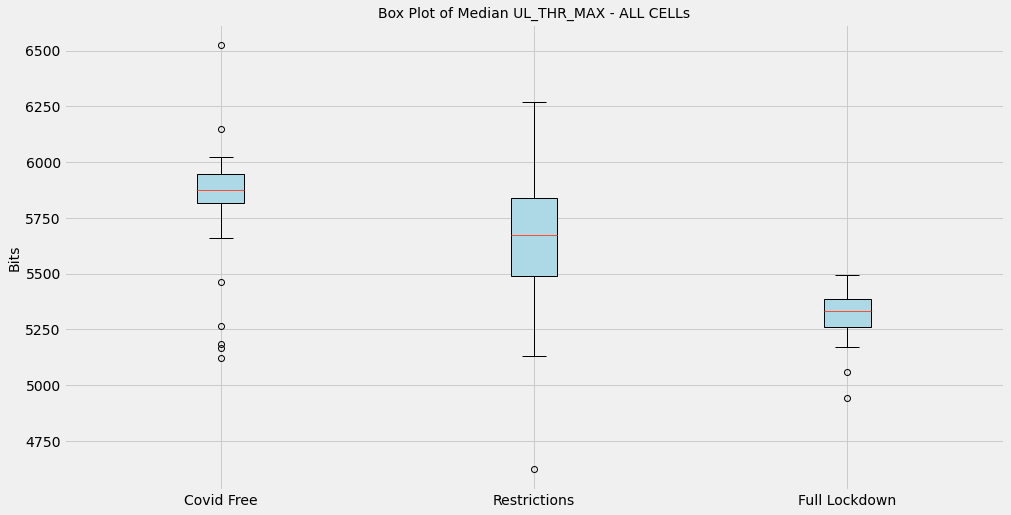


--------- Covid Free UL_THR_MAX ---------
Median value: 5875.97
Average value: 5832.88
Standard deviation: 242.88
--------- Restrictions UL_THR_MAX ---------
Median value: 5674.36
Average value: 5662.31
Standard deviation: 378.19
--------- Full Lockdown UL_THR_MAX ---------
Median value: 5333.43
Average value: 5303.49
Standard deviation: 128.26
>>>------ Covid Free UL_THR_MAX Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -3.43%
Average: difference between [ Covid Free ] and [ Restrictions ]: -2.92%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 55.71%
>>>------ Covid Free UL_THR_MAX Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: -9.23%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: -9.08%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -47.19%
>>>------ Restrictions UL_THR_MAX Variation ------<<<
Median: difference between [ Restrictions ] an

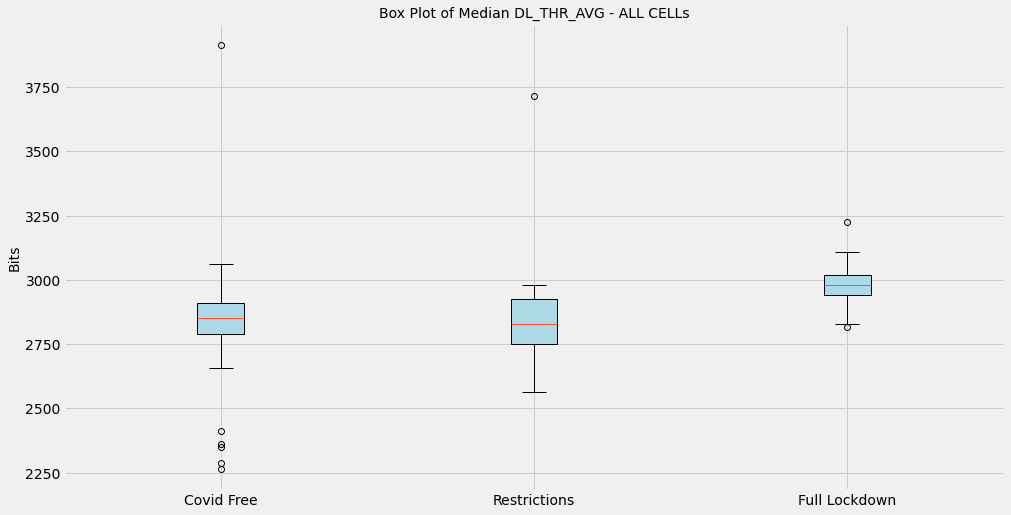


--------- Covid Free DL_THR_AVG ---------
Median value: 2851.08
Average value: 2822.99
Standard deviation: 239.82
--------- Restrictions DL_THR_AVG ---------
Median value: 2829.85
Average value: 2846.64
Standard deviation: 218.02
--------- Full Lockdown DL_THR_AVG ---------
Median value: 2979.95
Average value: 2982.10
Standard deviation: 90.86
>>>------ Covid Free DL_THR_AVG Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -0.74%
Average: difference between [ Covid Free ] and [ Restrictions ]: 0.84%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: -9.09%
>>>------ Covid Free DL_THR_AVG Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 4.52%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 5.64%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -62.11%
>>>------ Restrictions DL_THR_AVG Variation ------<<<
Median: difference between [ Restrictions ] and [ 

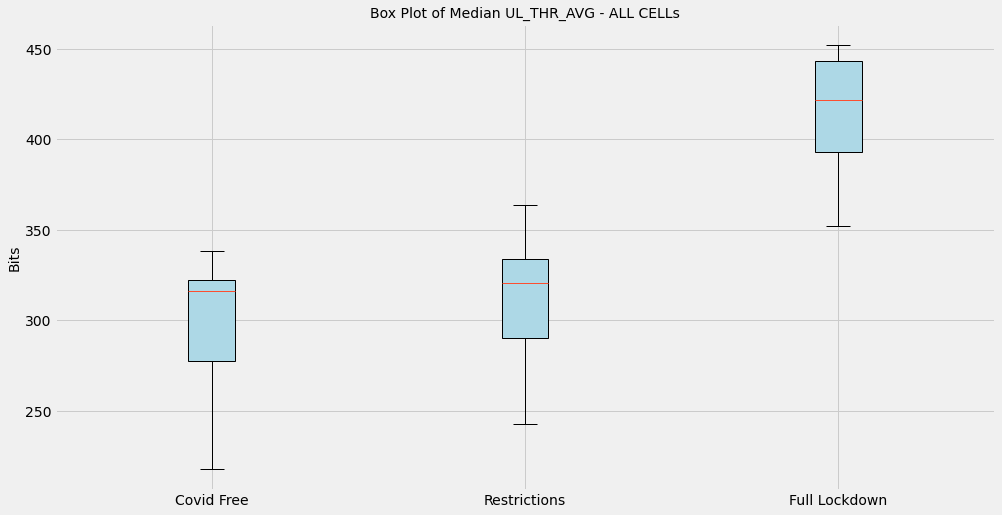


--------- Covid Free UL_THR_AVG ---------
Median value: 316.21
Average value: 298.66
Standard deviation: 32.52
--------- Restrictions UL_THR_AVG ---------
Median value: 320.31
Average value: 310.13
Standard deviation: 33.48
--------- Full Lockdown UL_THR_AVG ---------
Median value: 421.88
Average value: 416.74
Standard deviation: 29.52
>>>------ Covid Free UL_THR_AVG Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: 1.30%
Average: difference between [ Covid Free ] and [ Restrictions ]: 3.84%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 2.96%
>>>------ Covid Free UL_THR_AVG Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 33.41%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 39.54%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -9.23%
>>>------ Restrictions UL_THR_AVG Variation ------<<<
Median: difference between [ Restrictions ] and [ Full Lock

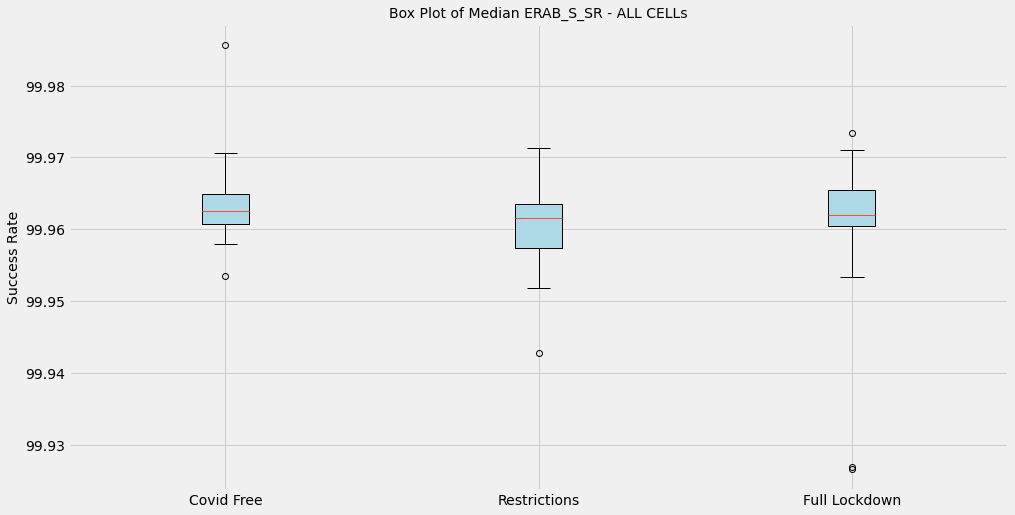


--------- Covid Free ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.00
--------- Restrictions ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.01
--------- Full Lockdown ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.01
>>>------ Covid Free ERAB_S_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -0.00%
Average: difference between [ Covid Free ] and [ Restrictions ]: -0.00%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 29.56%
>>>------ Covid Free ERAB_S_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: -0.00%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: -0.00%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: 136.08%
>>>------ Restrictions ERAB_S_SR Variation ------<<<
Median: difference between [ Restrictions ] and [ Full Lockdown ]: 0.0

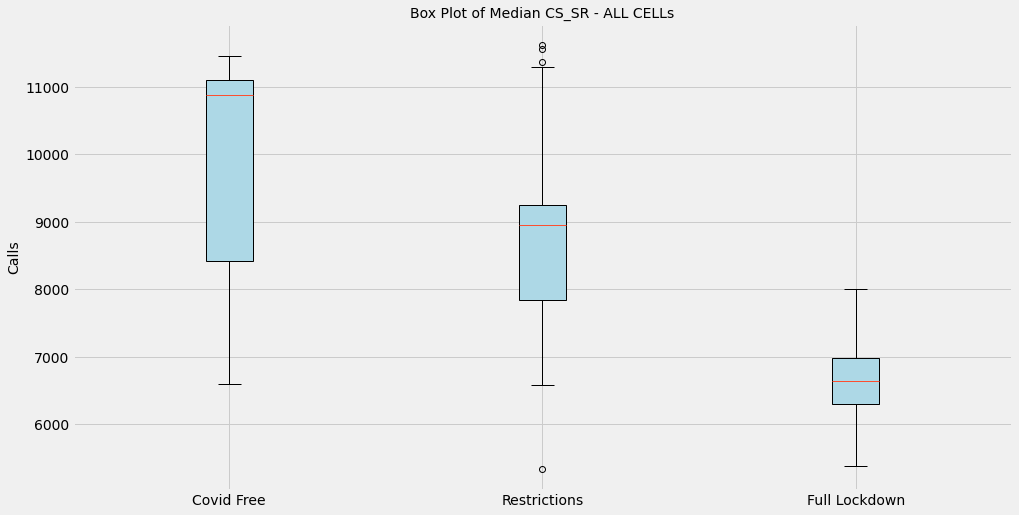


--------- Covid Free CS_SR ---------
Median value: 10881.89
Average value: 9870.74
Standard deviation: 1529.75
--------- Restrictions CS_SR ---------
Median value: 8950.49
Average value: 8801.19
Standard deviation: 1643.62
--------- Full Lockdown CS_SR ---------
Median value: 6640.26
Average value: 6731.95
Standard deviation: 633.76
>>>------ Covid Free CS_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -17.75%
Average: difference between [ Covid Free ] and [ Restrictions ]: -10.84%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 7.44%
>>>------ Covid Free CS_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: -38.98%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: -31.80%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -58.57%
>>>------ Restrictions CS_SR Variation ------<<<
Median: difference between [ Restrictions ] and [ Full Lockdown ]: -25

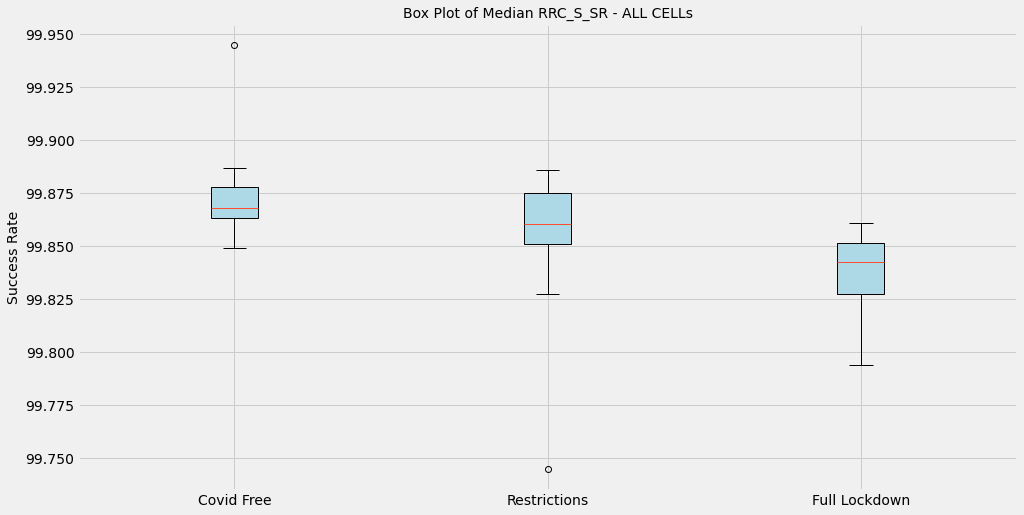


--------- Covid Free RRC_S_SR ---------
Median value: 99.87
Average value: 99.87
Standard deviation: 0.01
--------- Restrictions RRC_S_SR ---------
Median value: 99.86
Average value: 99.86
Standard deviation: 0.03
--------- Full Lockdown RRC_S_SR ---------
Median value: 99.84
Average value: 99.84
Standard deviation: 0.02
>>>------ Covid Free RRC_S_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -0.01%
Average: difference between [ Covid Free ] and [ Restrictions ]: -0.01%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 99.34%
>>>------ Covid Free RRC_S_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: -0.03%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: -0.03%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: 31.34%
>>>------ Restrictions RRC_S_SR Variation ------<<<
Median: difference between [ Restrictions ] and [ Full Lockdown ]: -0.02%
Ave

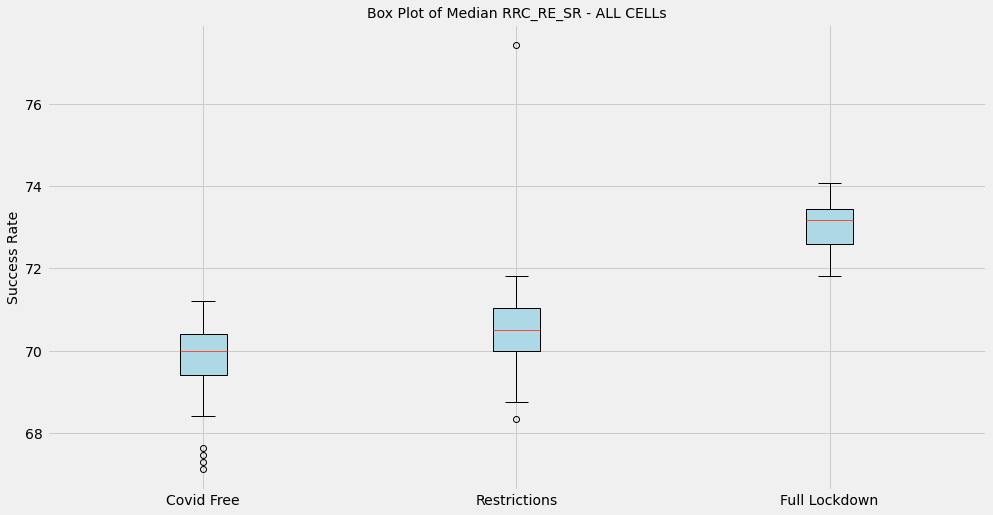


--------- Covid Free RRC_RE_SR ---------
Median value: 69.99
Average value: 69.77
Standard deviation: 0.95
--------- Restrictions RRC_RE_SR ---------
Median value: 70.50
Average value: 70.67
Standard deviation: 1.63
--------- Full Lockdown RRC_RE_SR ---------
Median value: 73.17
Average value: 73.05
Standard deviation: 0.60
>>>------ Covid Free RRC_RE_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: 0.73%
Average: difference between [ Covid Free ] and [ Restrictions ]: 1.28%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 71.04%
>>>------ Covid Free RRC_RE_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 4.54%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 4.70%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -37.29%
>>>------ Restrictions RRC_RE_SR Variation ------<<<
Median: difference between [ Restrictions ] and [ Full Lockdown ]: 3.79%
A

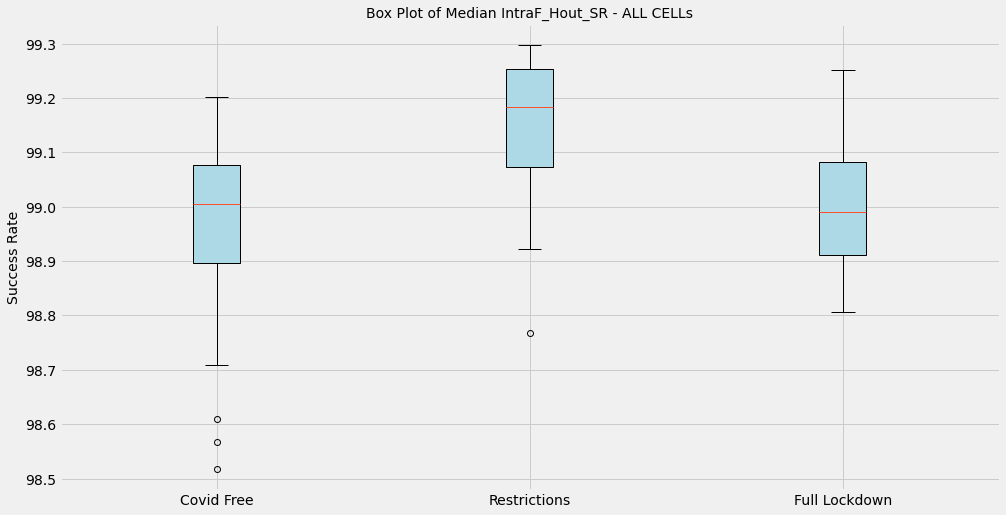


--------- Covid Free IntraF_Hout_SR ---------
Median value: 99.01
Average value: 98.97
Standard deviation: 0.16
--------- Restrictions IntraF_Hout_SR ---------
Median value: 99.18
Average value: 99.15
Standard deviation: 0.13
--------- Full Lockdown IntraF_Hout_SR ---------
Median value: 98.99
Average value: 99.00
Standard deviation: 0.12
>>>------ Covid Free IntraF_Hout_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: 0.18%
Average: difference between [ Covid Free ] and [ Restrictions ]: 0.18%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: -20.25%
>>>------ Covid Free IntraF_Hout_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: -0.02%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 0.03%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -28.06%
>>>------ Restrictions IntraF_Hout_SR Variation ------<<<
Median: difference between [ Restrictions 

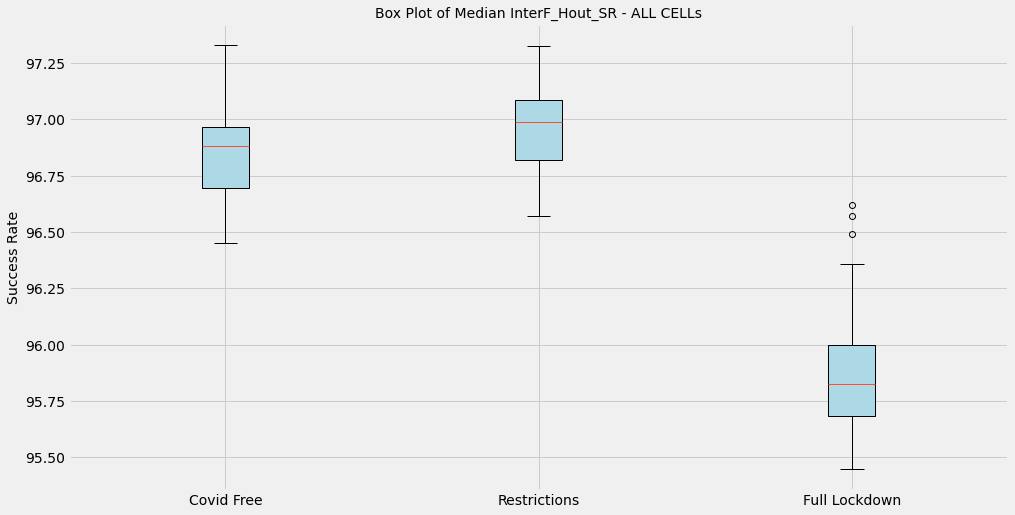


--------- Covid Free InterF_Hout_SR ---------
Median value: 96.88
Average value: 96.85
Standard deviation: 0.21
--------- Restrictions InterF_Hout_SR ---------
Median value: 96.99
Average value: 96.97
Standard deviation: 0.20
--------- Full Lockdown InterF_Hout_SR ---------
Median value: 95.82
Average value: 95.91
Standard deviation: 0.32
>>>------ Covid Free InterF_Hout_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: 0.11%
Average: difference between [ Covid Free ] and [ Restrictions ]: 0.12%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: -4.99%
>>>------ Covid Free InterF_Hout_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: -1.09%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: -0.97%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: 52.92%
>>>------ Restrictions InterF_Hout_SR Variation ------<<<
Median: difference between [ Restrictions ]

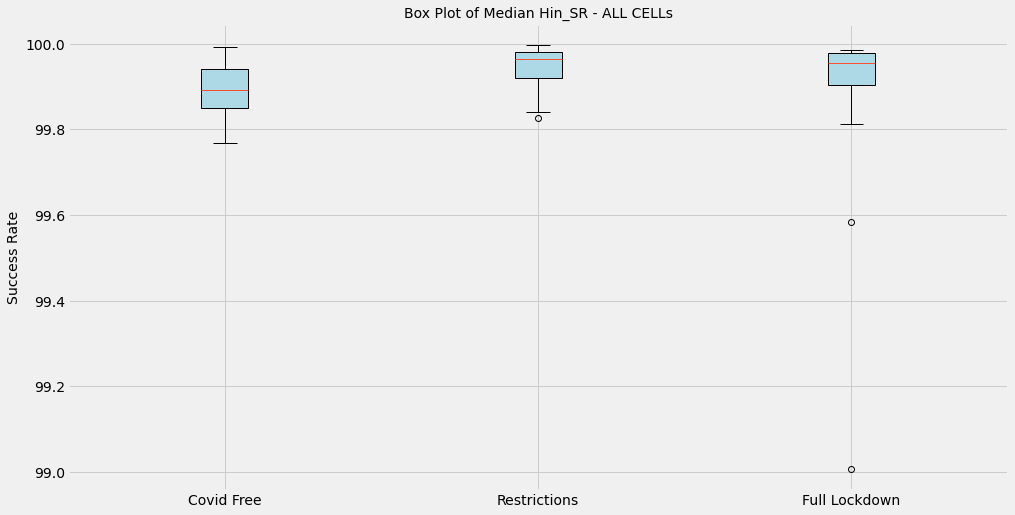


--------- Covid Free Hin_SR ---------
Median value: 99.89
Average value: 99.90
Standard deviation: 0.06
--------- Restrictions Hin_SR ---------
Median value: 99.96
Average value: 99.94
Standard deviation: 0.05
--------- Full Lockdown Hin_SR ---------
Median value: 99.95
Average value: 99.88
Standard deviation: 0.21
>>>------ Covid Free Hin_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: 0.07%
Average: difference between [ Covid Free ] and [ Restrictions ]: 0.05%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: -13.86%
>>>------ Covid Free Hin_SR Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 0.06%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: -0.01%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: 258.46%
>>>------ Restrictions Hin_SR Variation ------<<<
Median: difference between [ Restrictions ] and [ Full Lockdown ]: -0.01%
Average: differe

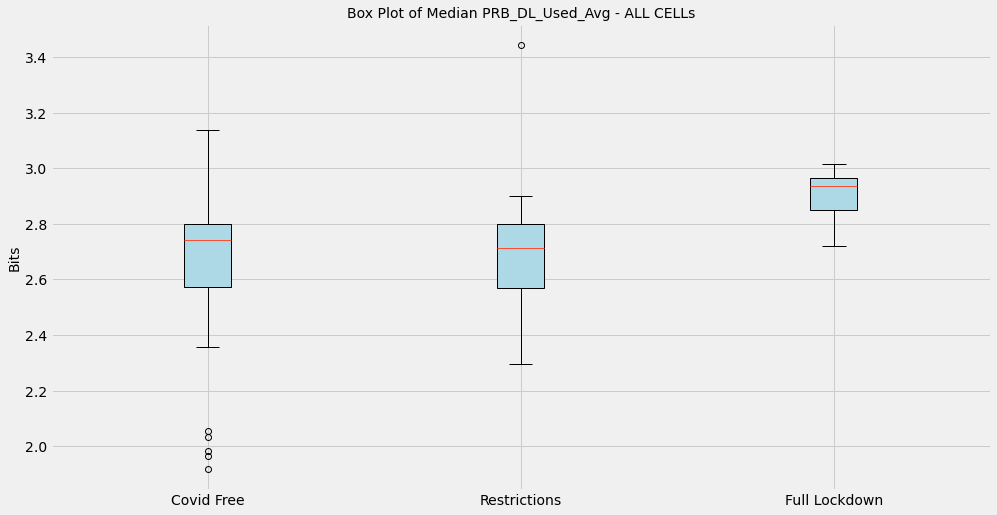


--------- Covid Free PRB_DL_Used_Avg ---------
Median value: 2.74
Average value: 2.64
Standard deviation: 0.26
--------- Restrictions PRB_DL_Used_Avg ---------
Median value: 2.71
Average value: 2.69
Standard deviation: 0.23
--------- Full Lockdown PRB_DL_Used_Avg ---------
Median value: 2.94
Average value: 2.90
Standard deviation: 0.09
>>>------ Covid Free PRB_DL_Used_Avg Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -1.02%
Average: difference between [ Covid Free ] and [ Restrictions ]: 1.84%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: -11.47%
>>>------ Covid Free PRB_DL_Used_Avg Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 7.09%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 9.77%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -65.73%
>>>------ Restrictions PRB_DL_Used_Avg Variation ------<<<
Median: difference between [ Restrictions 

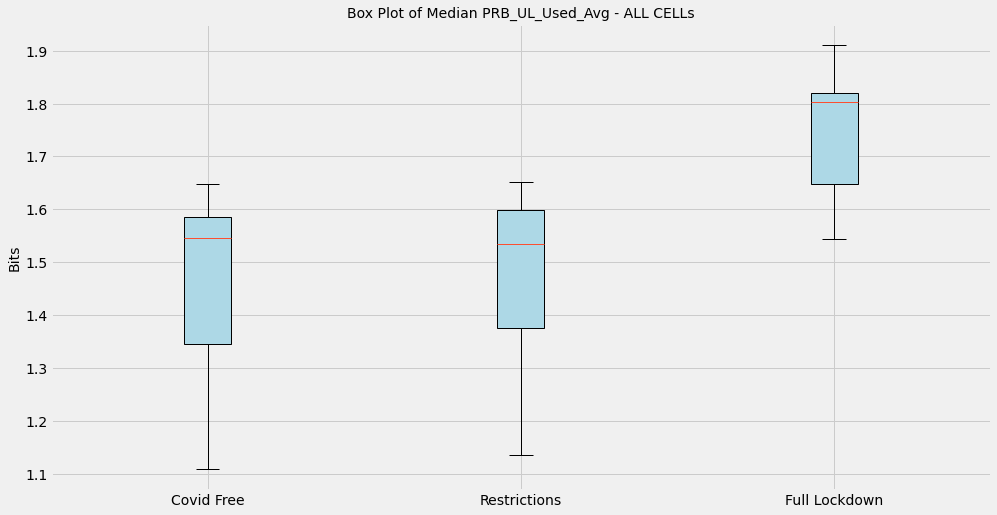


--------- Covid Free PRB_UL_Used_Avg ---------
Median value: 1.55
Average value: 1.46
Standard deviation: 0.16
--------- Restrictions PRB_UL_Used_Avg ---------
Median value: 1.53
Average value: 1.47
Standard deviation: 0.16
--------- Full Lockdown PRB_UL_Used_Avg ---------
Median value: 1.80
Average value: 1.75
Standard deviation: 0.11
>>>------ Covid Free PRB_UL_Used_Avg Variation ------<<<
Median: difference between [ Covid Free ] and [ Restrictions ]: -0.71%
Average: difference between [ Covid Free ] and [ Restrictions ]: 0.81%
Std. deviation: difference between [ Covid Free ] and [ Restrictions ]: 2.24%
>>>------ Covid Free PRB_UL_Used_Avg Variation ------<<<
Median: difference between [ Covid Free ] and [ Full Lockdown ]: 16.70%
Average: difference between [ Covid Free ] and [ Full Lockdown ]: 19.93%
Std. deviation: difference between [ Covid Free ] and [ Full Lockdown ]: -31.54%
>>>------ Restrictions PRB_UL_Used_Avg Variation ------<<<
Median: difference between [ Restrictions 

In [49]:
periods = [covid_free, restrictions, full_lockdown]
plot_stats(periods, periods_lables)

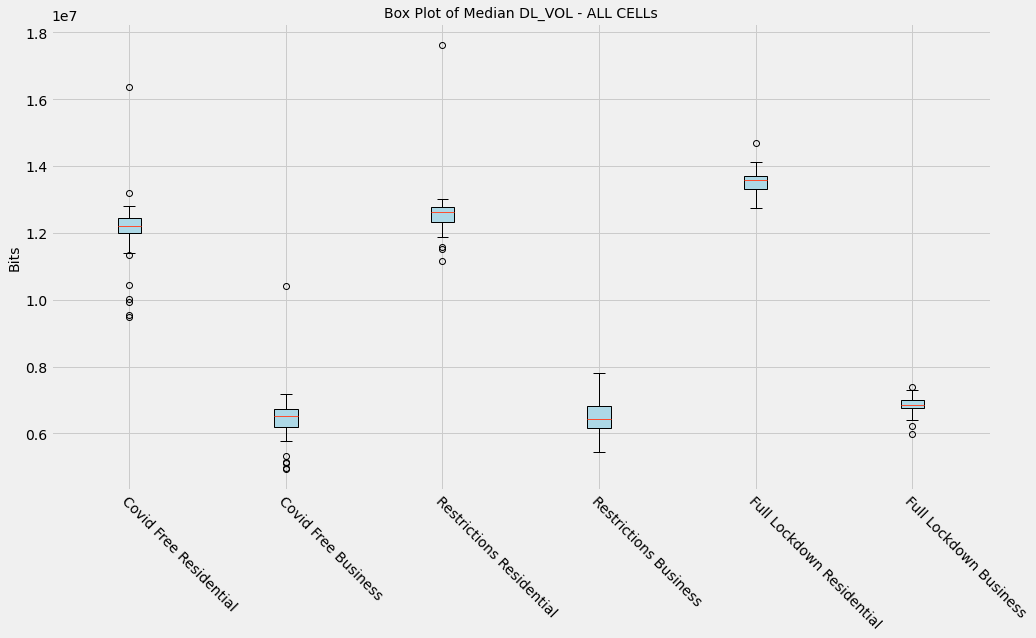


--------- Covid Free Residential DL_VOL ---------
Median value: 12203941.61
Average value: 12064829.17
Standard deviation: 1022164.72
--------- Covid Free Business DL_VOL ---------
Median value: 6527226.71
Average value: 6467114.35
Standard deviation: 787622.00
--------- Restrictions Residential DL_VOL ---------
Median value: 12629167.16
Average value: 12652893.63
Standard deviation: 1140492.39
--------- Restrictions Business DL_VOL ---------
Median value: 6418769.10
Average value: 6476662.69
Standard deviation: 558834.45
--------- Full Lockdown Residential DL_VOL ---------
Median value: 13585264.28
Average value: 13520003.72
Standard deviation: 448983.75
--------- Full Lockdown Business DL_VOL ---------
Median value: 6844946.17
Average value: 6809451.97
Standard deviation: 317985.78
>>>------ Covid Free Residential DL_VOL Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -46.52%
Average: difference between [ Covid Free Residential 

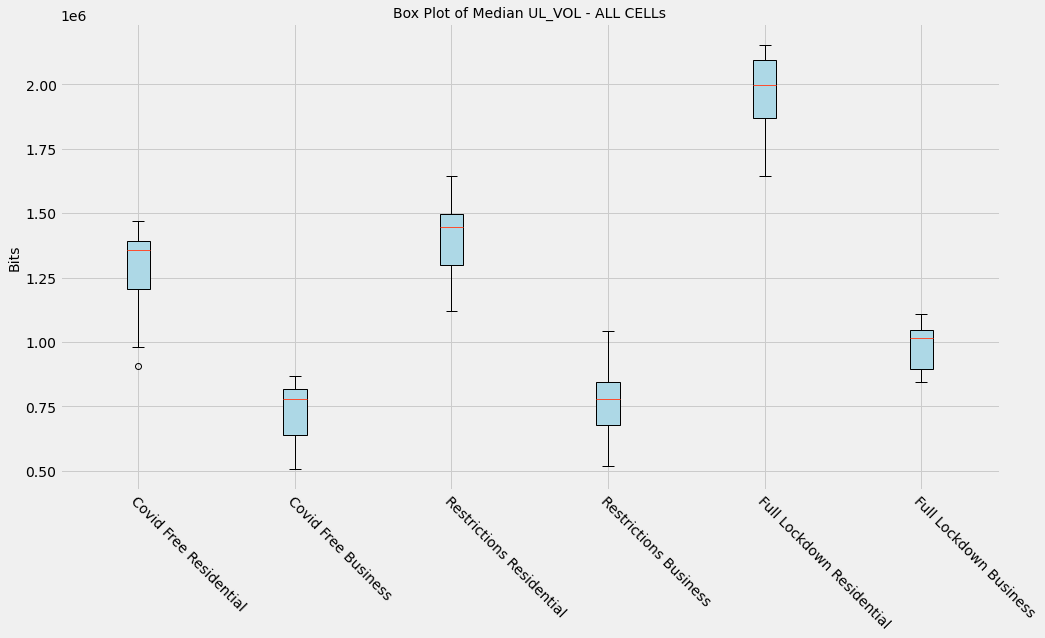


--------- Covid Free Residential UL_VOL ---------
Median value: 1357850.27
Average value: 1293570.99
Standard deviation: 137170.84
--------- Covid Free Business UL_VOL ---------
Median value: 779760.91
Average value: 732753.76
Standard deviation: 107282.42
--------- Restrictions Residential UL_VOL ---------
Median value: 1446571.99
Average value: 1398781.34
Standard deviation: 139789.63
--------- Restrictions Business UL_VOL ---------
Median value: 779722.17
Average value: 757218.92
Standard deviation: 122534.18
--------- Full Lockdown Residential UL_VOL ---------
Median value: 1998740.52
Average value: 1970341.61
Standard deviation: 148904.92
--------- Full Lockdown Business UL_VOL ---------
Median value: 1015748.63
Average value: 985099.23
Standard deviation: 87153.15
>>>------ Covid Free Residential UL_VOL Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -42.57%
Average: difference between [ Covid Free Residential ] and [ Covid 

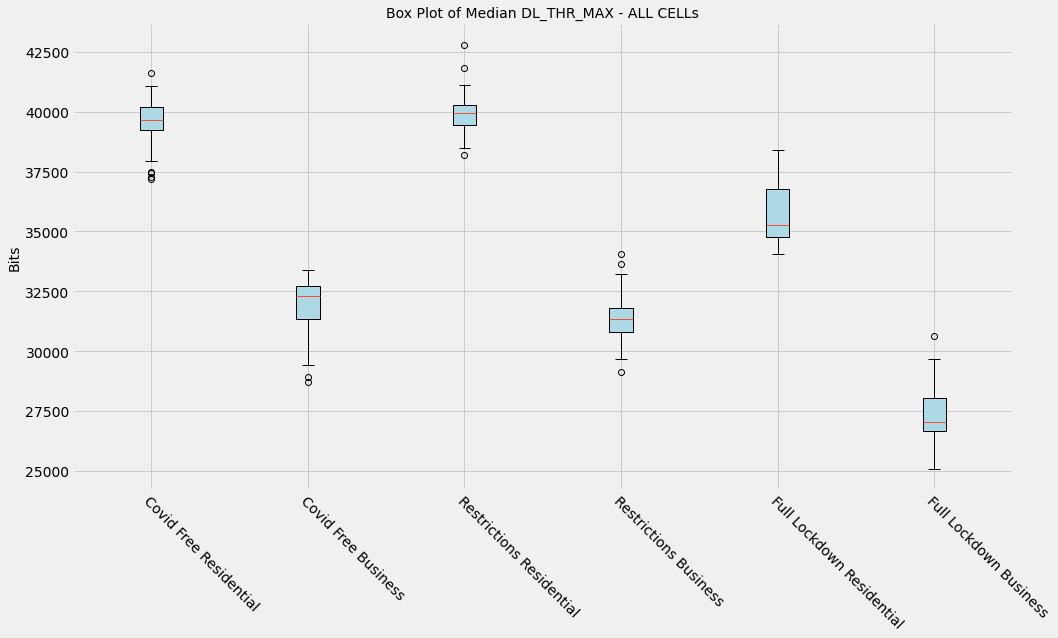


--------- Covid Free Residential DL_THR_MAX ---------
Median value: 39665.57
Average value: 39600.43
Standard deviation: 983.19
--------- Covid Free Business DL_THR_MAX ---------
Median value: 32312.56
Average value: 31879.22
Standard deviation: 1185.66
--------- Restrictions Residential DL_THR_MAX ---------
Median value: 39927.89
Average value: 40012.37
Standard deviation: 995.41
--------- Restrictions Business DL_THR_MAX ---------
Median value: 31332.89
Average value: 31416.81
Standard deviation: 1190.05
--------- Full Lockdown Residential DL_THR_MAX ---------
Median value: 35282.04
Average value: 35705.55
Standard deviation: 1265.16
--------- Full Lockdown Business DL_THR_MAX ---------
Median value: 27031.60
Average value: 27442.69
Standard deviation: 1370.35
>>>------ Covid Free Residential DL_THR_MAX Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -18.54%
Average: difference between [ Covid Free Residential ] and [ Covid Free

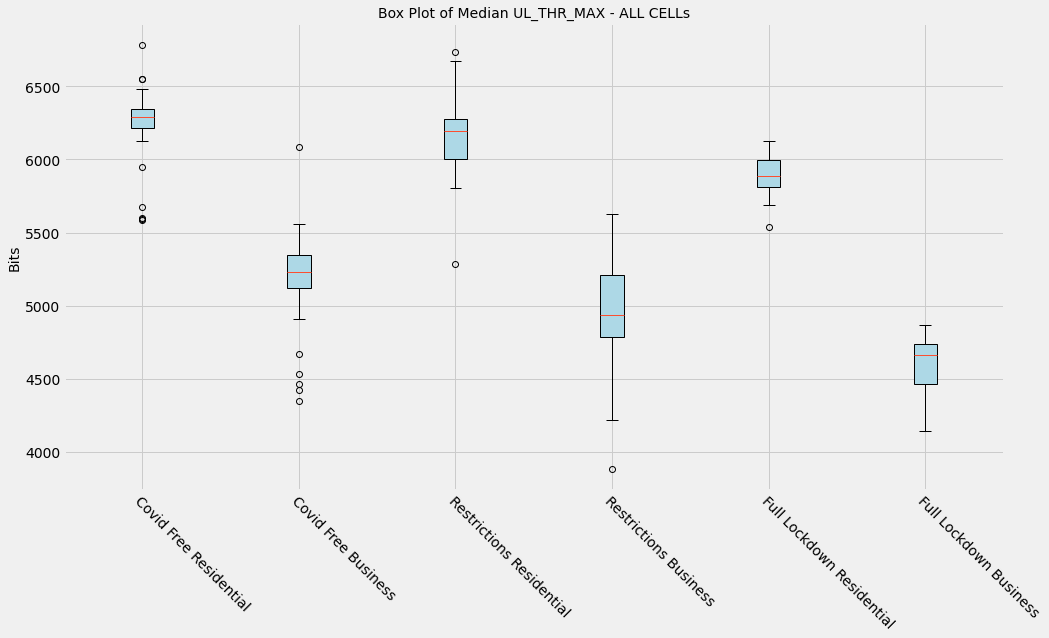


--------- Covid Free Residential UL_THR_MAX ---------
Median value: 6290.80
Average value: 6250.62
Standard deviation: 229.73
--------- Covid Free Business UL_THR_MAX ---------
Median value: 5229.60
Average value: 5186.52
Standard deviation: 308.65
--------- Restrictions Residential UL_THR_MAX ---------
Median value: 6193.74
Average value: 6181.58
Standard deviation: 320.86
--------- Restrictions Business UL_THR_MAX ---------
Median value: 4934.47
Average value: 4952.94
Standard deviation: 427.51
--------- Full Lockdown Residential UL_THR_MAX ---------
Median value: 5888.68
Average value: 5892.01
Standard deviation: 133.76
--------- Full Lockdown Business UL_THR_MAX ---------
Median value: 4662.46
Average value: 4599.49
Standard deviation: 180.73
>>>------ Covid Free Residential UL_THR_MAX Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -16.87%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -17

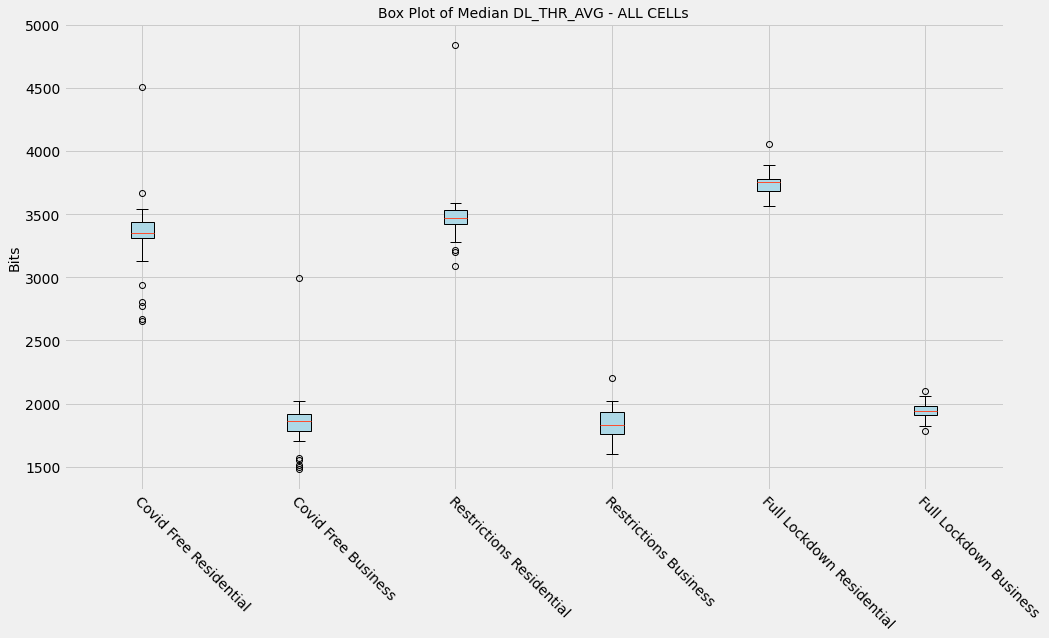


--------- Covid Free Residential DL_THR_AVG ---------
Median value: 3354.06
Average value: 3336.52
Standard deviation: 273.41
--------- Covid Free Business DL_THR_AVG ---------
Median value: 1865.59
Average value: 1854.34
Standard deviation: 209.72
--------- Restrictions Residential DL_THR_AVG ---------
Median value: 3469.11
Average value: 3491.68
Standard deviation: 308.09
--------- Restrictions Business DL_THR_AVG ---------
Median value: 1833.64
Average value: 1844.20
Standard deviation: 140.41
--------- Full Lockdown Residential DL_THR_AVG ---------
Median value: 3753.30
Average value: 3739.62
Standard deviation: 110.85
--------- Full Lockdown Business DL_THR_AVG ---------
Median value: 1939.56
Average value: 1935.36
Standard deviation: 74.41
>>>------ Covid Free Residential DL_THR_AVG Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -44.38%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -44.

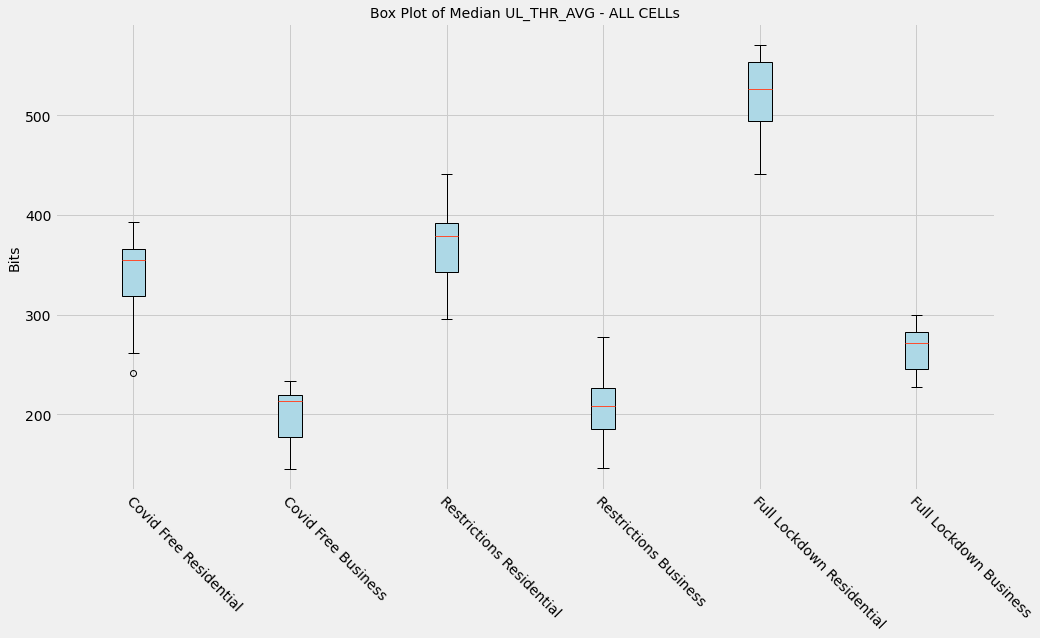


--------- Covid Free Residential UL_THR_AVG ---------
Median value: 354.36
Average value: 340.96
Standard deviation: 34.94
--------- Covid Free Business UL_THR_AVG ---------
Median value: 213.29
Average value: 199.93
Standard deviation: 25.80
--------- Restrictions Residential UL_THR_AVG ---------
Median value: 378.74
Average value: 367.94
Standard deviation: 36.56
--------- Restrictions Business UL_THR_AVG ---------
Median value: 208.26
Average value: 204.12
Standard deviation: 30.28
--------- Full Lockdown Residential UL_THR_AVG ---------
Median value: 525.91
Average value: 521.62
Standard deviation: 37.64
--------- Full Lockdown Business UL_THR_AVG ---------
Median value: 271.87
Average value: 266.57
Standard deviation: 21.81
>>>------ Covid Free Residential UL_THR_AVG Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -39.81%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -41.36%
Std. deviatio

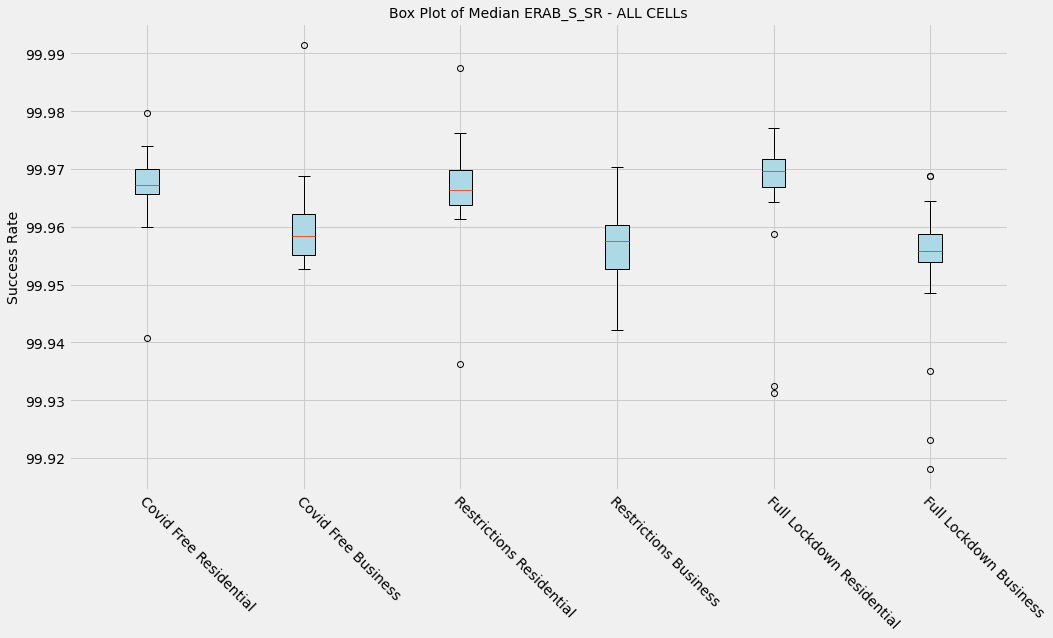


--------- Covid Free Residential ERAB_S_SR ---------
Median value: 99.97
Average value: 99.97
Standard deviation: 0.01
--------- Covid Free Business ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.01
--------- Restrictions Residential ERAB_S_SR ---------
Median value: 99.97
Average value: 99.97
Standard deviation: 0.01
--------- Restrictions Business ERAB_S_SR ---------
Median value: 99.96
Average value: 99.96
Standard deviation: 0.01
--------- Full Lockdown Residential ERAB_S_SR ---------
Median value: 99.97
Average value: 99.97
Standard deviation: 0.01
--------- Full Lockdown Business ERAB_S_SR ---------
Median value: 99.96
Average value: 99.95
Standard deviation: 0.01
>>>------ Covid Free Residential ERAB_S_SR Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.01%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.01%
Std. deviation: difference between [ Cov

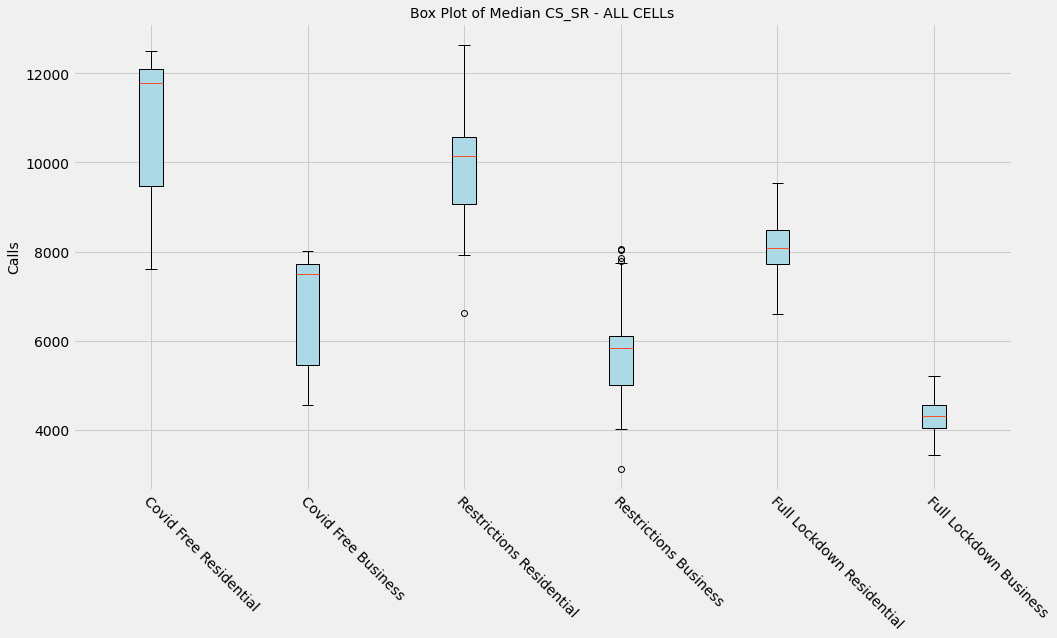


--------- Covid Free Residential CS_SR ---------
Median value: 11782.95
Average value: 10865.77
Standard deviation: 1544.39
--------- Covid Free Business CS_SR ---------
Median value: 7485.76
Average value: 6712.31
Standard deviation: 1196.15
--------- Restrictions Residential CS_SR ---------
Median value: 10152.91
Average value: 10031.38
Standard deviation: 1545.04
--------- Restrictions Business CS_SR ---------
Median value: 5832.28
Average value: 5789.52
Standard deviation: 1328.56
--------- Full Lockdown Residential CS_SR ---------
Median value: 8086.13
Average value: 8169.92
Standard deviation: 707.48
--------- Full Lockdown Business CS_SR ---------
Median value: 4298.72
Average value: 4333.19
Standard deviation: 445.06
>>>------ Covid Free Residential CS_SR Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -36.47%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -38.23%
Std. deviation: differ

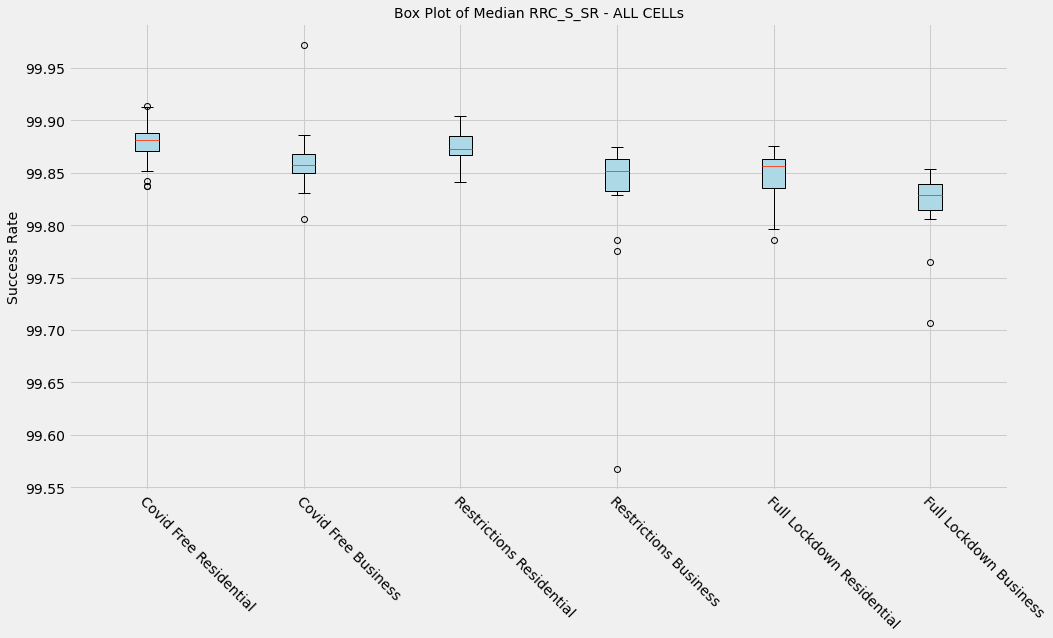


--------- Covid Free Residential RRC_S_SR ---------
Median value: 99.88
Average value: 99.88
Standard deviation: 0.02
--------- Covid Free Business RRC_S_SR ---------
Median value: 99.86
Average value: 99.86
Standard deviation: 0.02
--------- Restrictions Residential RRC_S_SR ---------
Median value: 99.87
Average value: 99.88
Standard deviation: 0.02
--------- Restrictions Business RRC_S_SR ---------
Median value: 99.85
Average value: 99.83
Standard deviation: 0.06
--------- Full Lockdown Residential RRC_S_SR ---------
Median value: 99.86
Average value: 99.85
Standard deviation: 0.02
--------- Full Lockdown Business RRC_S_SR ---------
Median value: 99.83
Average value: 99.82
Standard deviation: 0.03
>>>------ Covid Free Residential RRC_S_SR Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.02%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -0.02%
Std. deviation: difference between [ Covid Free

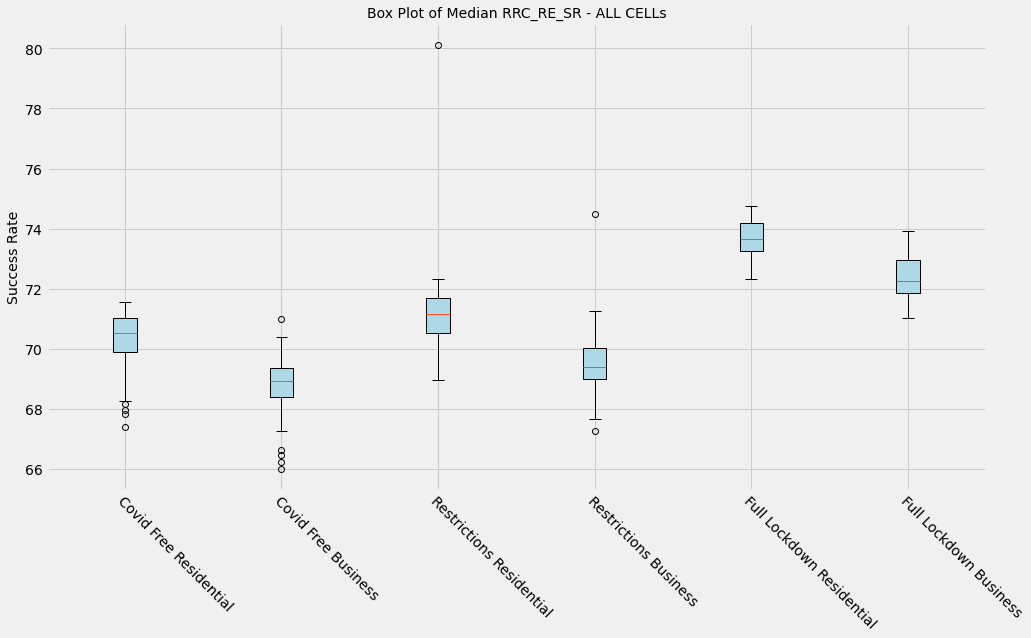


--------- Covid Free Residential RRC_RE_SR ---------
Median value: 70.53
Average value: 70.29
Standard deviation: 1.06
--------- Covid Free Business RRC_RE_SR ---------
Median value: 68.91
Average value: 68.78
Standard deviation: 1.08
--------- Restrictions Residential RRC_RE_SR ---------
Median value: 71.16
Average value: 71.38
Standard deviation: 2.00
--------- Restrictions Business RRC_RE_SR ---------
Median value: 69.40
Average value: 69.64
Standard deviation: 1.37
--------- Full Lockdown Residential RRC_RE_SR ---------
Median value: 73.66
Average value: 73.71
Standard deviation: 0.64
--------- Full Lockdown Business RRC_RE_SR ---------
Median value: 72.27
Average value: 72.37
Standard deviation: 0.78
>>>------ Covid Free Residential RRC_RE_SR Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -2.30%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -2.16%
Std. deviation: difference between [ Cov

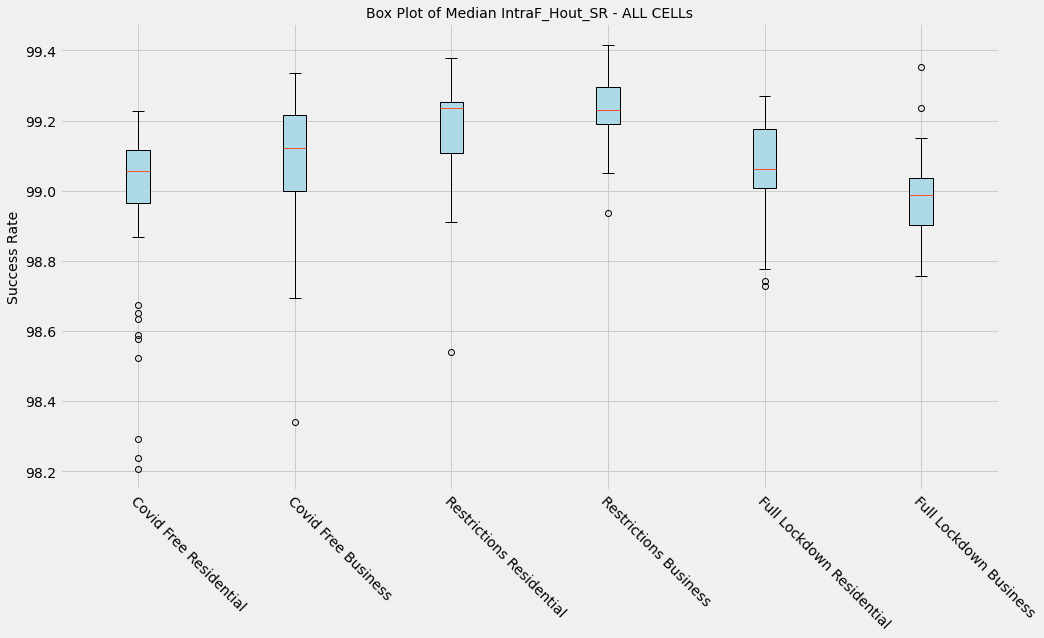


--------- Covid Free Residential IntraF_Hout_SR ---------
Median value: 99.05
Average value: 98.96
Standard deviation: 0.25
--------- Covid Free Business IntraF_Hout_SR ---------
Median value: 99.12
Average value: 99.09
Standard deviation: 0.18
--------- Restrictions Residential IntraF_Hout_SR ---------
Median value: 99.24
Average value: 99.16
Standard deviation: 0.18
--------- Restrictions Business IntraF_Hout_SR ---------
Median value: 99.23
Average value: 99.23
Standard deviation: 0.10
--------- Full Lockdown Residential IntraF_Hout_SR ---------
Median value: 99.06
Average value: 99.05
Standard deviation: 0.16
--------- Full Lockdown Business IntraF_Hout_SR ---------
Median value: 98.99
Average value: 98.99
Standard deviation: 0.13
>>>------ Covid Free Residential IntraF_Hout_SR Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 0.07%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 0.14%
Std. de

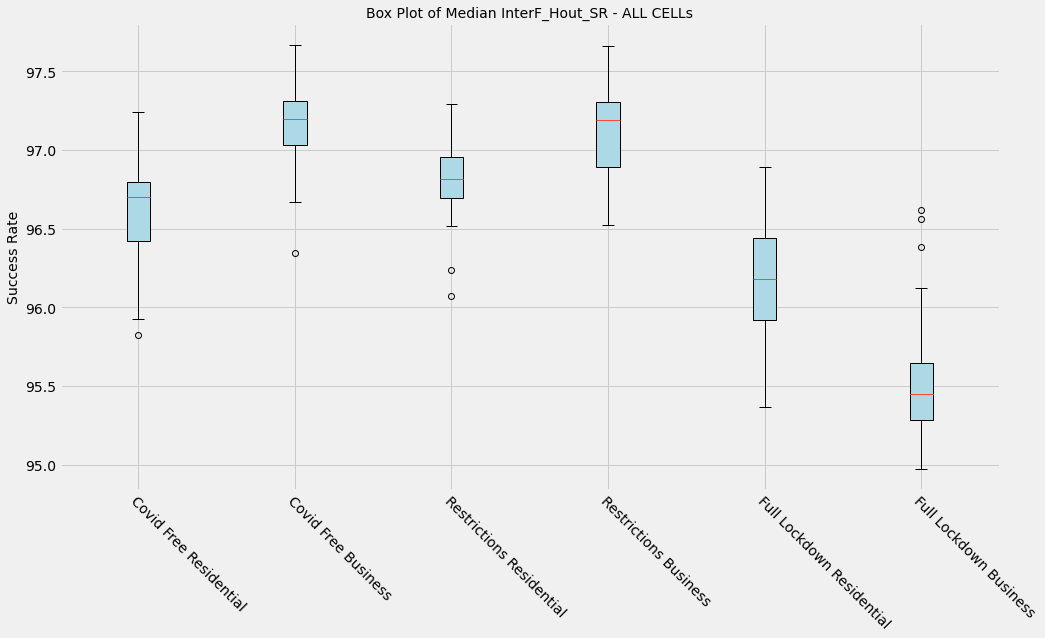


--------- Covid Free Residential InterF_Hout_SR ---------
Median value: 96.70
Average value: 96.62
Standard deviation: 0.31
--------- Covid Free Business InterF_Hout_SR ---------
Median value: 97.20
Average value: 97.17
Standard deviation: 0.26
--------- Restrictions Residential InterF_Hout_SR ---------
Median value: 96.81
Average value: 96.82
Standard deviation: 0.29
--------- Restrictions Business InterF_Hout_SR ---------
Median value: 97.19
Average value: 97.13
Standard deviation: 0.28
--------- Full Lockdown Residential InterF_Hout_SR ---------
Median value: 96.18
Average value: 96.17
Standard deviation: 0.37
--------- Full Lockdown Business InterF_Hout_SR ---------
Median value: 95.45
Average value: 95.55
Standard deviation: 0.46
>>>------ Covid Free Residential InterF_Hout_SR Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 0.52%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 0.57%
Std. de

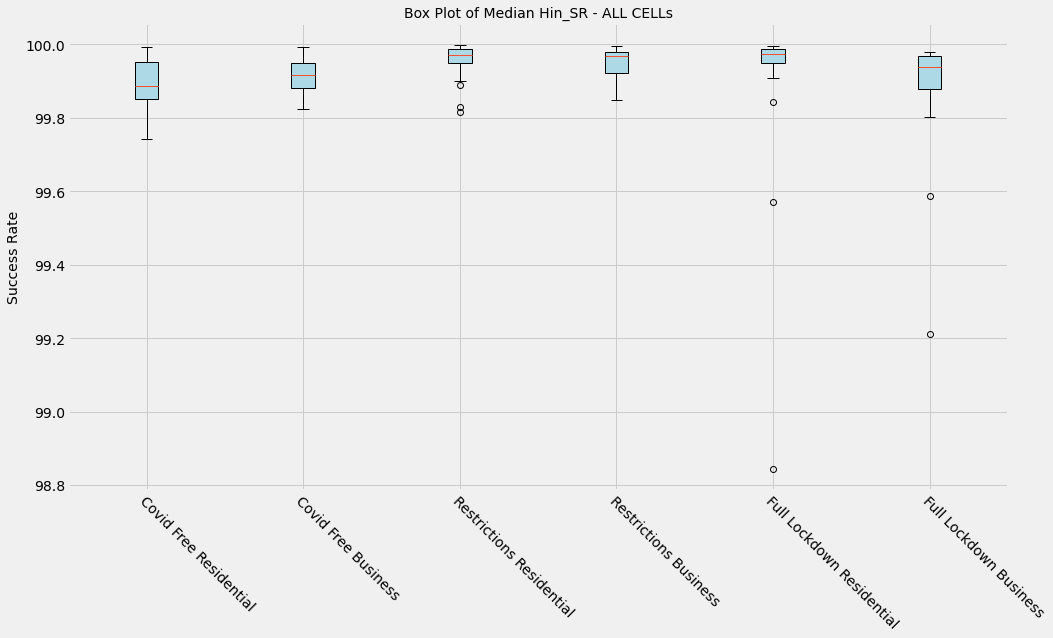


--------- Covid Free Residential Hin_SR ---------
Median value: 99.89
Average value: 99.90
Standard deviation: 0.06
--------- Covid Free Business Hin_SR ---------
Median value: 99.92
Average value: 99.92
Standard deviation: 0.05
--------- Restrictions Residential Hin_SR ---------
Median value: 99.97
Average value: 99.96
Standard deviation: 0.05
--------- Restrictions Business Hin_SR ---------
Median value: 99.97
Average value: 99.95
Standard deviation: 0.04
--------- Full Lockdown Residential Hin_SR ---------
Median value: 99.98
Average value: 99.90
Standard deviation: 0.25
--------- Full Lockdown Business Hin_SR ---------
Median value: 99.94
Average value: 99.88
Standard deviation: 0.17
>>>------ Covid Free Residential Hin_SR Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 0.03%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: 0.02%
Std. deviation: difference between [ Covid Free Residential ] a

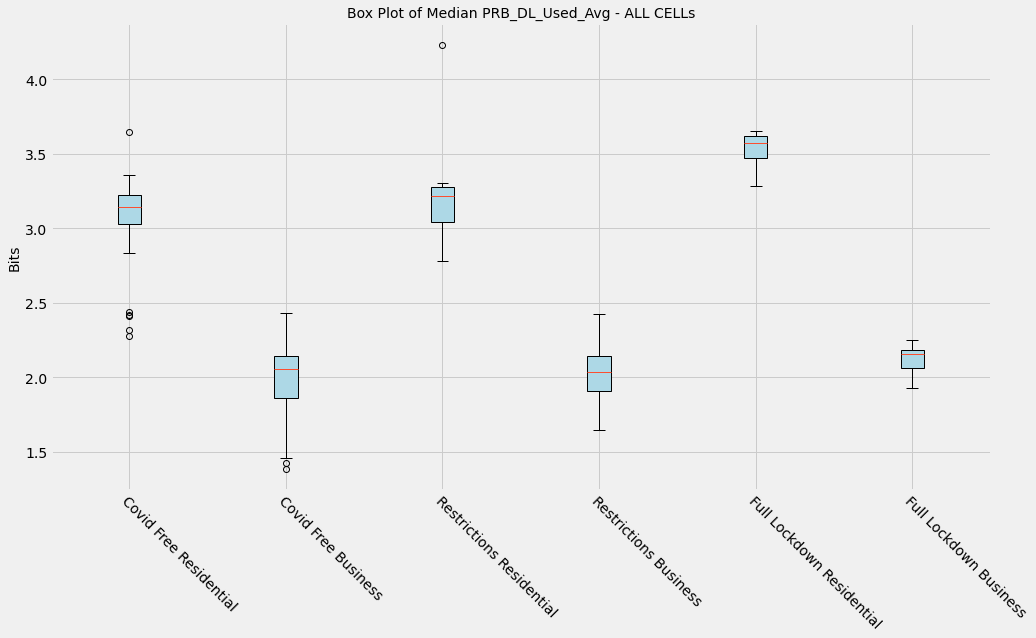


--------- Covid Free Residential PRB_DL_Used_Avg ---------
Median value: 3.14
Average value: 3.08
Standard deviation: 0.28
--------- Covid Free Business PRB_DL_Used_Avg ---------
Median value: 2.05
Average value: 1.98
Standard deviation: 0.24
--------- Restrictions Residential PRB_DL_Used_Avg ---------
Median value: 3.21
Average value: 3.18
Standard deviation: 0.27
--------- Restrictions Business PRB_DL_Used_Avg ---------
Median value: 2.04
Average value: 2.02
Standard deviation: 0.20
--------- Full Lockdown Residential PRB_DL_Used_Avg ---------
Median value: 3.57
Average value: 3.53
Standard deviation: 0.11
--------- Full Lockdown Business PRB_DL_Used_Avg ---------
Median value: 2.15
Average value: 2.13
Standard deviation: 0.08
>>>------ Covid Free Residential PRB_DL_Used_Avg Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -34.73%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -35.71%
Std. dev

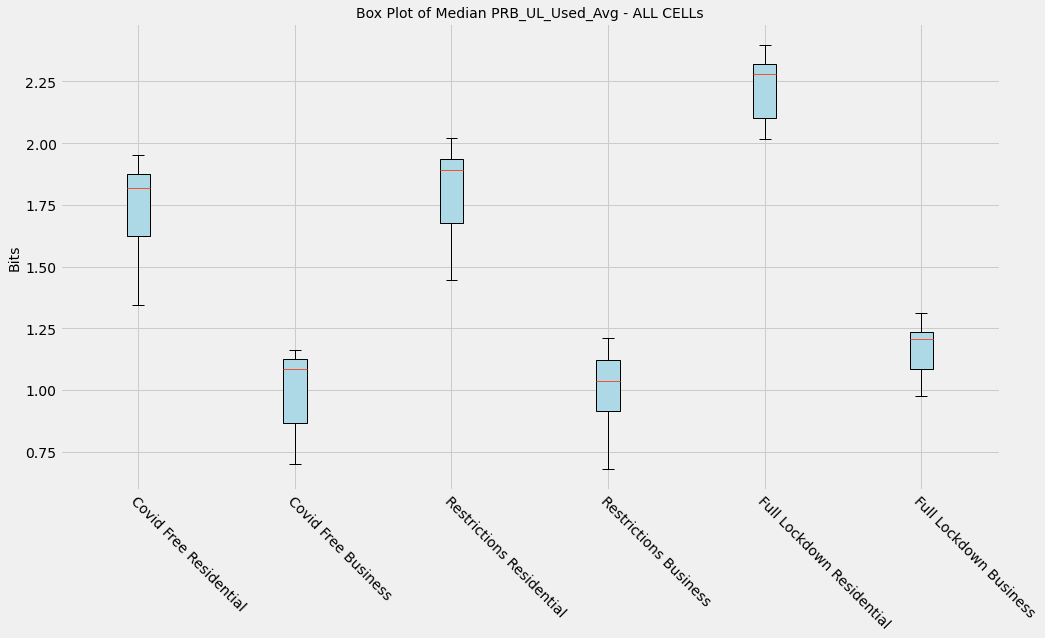


--------- Covid Free Residential PRB_UL_Used_Avg ---------
Median value: 1.82
Average value: 1.74
Standard deviation: 0.17
--------- Covid Free Business PRB_UL_Used_Avg ---------
Median value: 1.08
Average value: 1.00
Standard deviation: 0.15
--------- Restrictions Residential PRB_UL_Used_Avg ---------
Median value: 1.89
Average value: 1.81
Standard deviation: 0.18
--------- Restrictions Business PRB_UL_Used_Avg ---------
Median value: 1.04
Average value: 0.99
Standard deviation: 0.15
--------- Full Lockdown Residential PRB_UL_Used_Avg ---------
Median value: 2.28
Average value: 2.23
Standard deviation: 0.12
--------- Full Lockdown Business PRB_UL_Used_Avg ---------
Median value: 1.20
Average value: 1.17
Standard deviation: 0.10
>>>------ Covid Free Residential PRB_UL_Used_Avg Variation ------<<<
Median: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -40.45%
Average: difference between [ Covid Free Residential ] and [ Covid Free Business ]: -42.40%
Std. dev

In [50]:
periods = [covid_free_residential, covid_free_business, restrictions_residential, restrictions_business, full_lockdown_residential, full_lockdown_business]
periods_lables = ['Covid Free Residential', 'Covid Free Business', 'Restrictions Residential', 'Restrictions Business', 'Full Lockdown Residential', 'Full Lockdown Business']
plot_stats(periods, periods_lables)